# Systematic FX Volatility trading: Cross Sectional Relative Value

## Table of Contents
1. Economics and motivation
2. Math outline
3. Summary of attached code; which methods were coded from first principles and which were borrowed from the available libraries.
4. EDA
5. Examples of cointegration analysis and research of potential trading strategy
6. First comparison of Python and R implementations for Johansen procedure
7. Trading Strategies based on mean reversion:
    - Signal for discretionary directional trading
    - Semi-systematic with PCA factors
    - Systematic Stat Arb
8. Building blocks of systematic strategy:
    - Short outlines of steps and inputs
    - Statistical screening of candidates based on Engle-Granger and Johansen
    - More on comparison between Python and R for Johansen procedure
    - Further elimination based on economic properties or OU parameters
    - Choice of trading levels and weights
9. Backtest
    - Backtest outline and its shortcomings
    - Vega points performance
    - Dollar return performance
10. Discussion of further improvements of the strategy
11. Conclusion
12. Literature

## Introduction
Pairs Trading (and Statistical Arbitrage) is a very popular class of strategies for several reasons, most importantly because it has both a strong quantitative and fundamental background. Typically, by following a specific statistical procedure, a trader can construct a long/short portfolio that exhibits mean-reverting behavior. Under certain conditions, a strategy based on a systematic mean-reverting signal could be considered the closest thing to the holy grail of trading. It's no surprise that exploring mean-reverting signals is one of the first things that prospective quant traders learn to do. Both academic literature and online blogs are replete with detailed instructions on constructing stat arb portfolios.

With the wide availability of free financial data, statistical packages, and the decreasing cost of trading in the stock market, I believe that the alpha of trading pairs on developed market equities and ETFs may still exist, but the Sharpe ratio is probably materially lower than a decade ago.

In this project, I will attempt to research pairs trading signals within one of the markets considered to be "alternative"—the OTC foreign exchange volatility market. The motivation behind this choice is that the strategy may not be as crowded, given that significantly fewer quantitative traders have access to this market. Additionally, both backtesting and trading are more complex compared to equities.

Moreover, from my observations, the fundamental reason why the strategy works is especially strong for this market. Before introducing any mathematical models, we can intuitively understand that volatilities of the most traded currencies react similarly to the same global factors, especially when these currencies belong to countries with similar geography, economic structures, or other close connections. Besides global impacts, there are, of course, idiosyncratic factors driven by local fundamentals or differences in liquidity.

My fundamental reason for seeing strong potential for pairs trading based on a panel of FX volatilities is that macroeconomic conditions in developed countries tend to synchronize. But, most importantly, I believe there is a technical or market structure-based reason to believe in the strategy: trading long/short pairs of volatilities will be de facto one-sided liquidity provision to the market when a large order disturbs the vols in one of the currencies.

If we simplify, the FX volatilities market mainly consists of customers who directionally trade FX options for hedging or speculative reasons and liquidity providers (usually large banks) who quote for the customers but run a delta-neutral book. Over the past decades, various regulators have compelled many customers to hedge their FX risks, and simultaneously, banks' mandates and risk limits have become more strict. In such a situation, liquidity from primary market LPs may not be enough to sustain implied volatilities close to "fair" levels, and other market participants have to step in. Relative value volatility traders are one group of such participants (though not the only one). By identifying rich and cheap volatilities, they help facilitate customers' flow, perhaps even without directly dealing with customers.

I hope I have managed to explain the motivation behind my choice of the project and the market. Now, I should say a little about how exactly I am planning to conduct the research. I obtained a dataset, which is a panel of at-the-money implied volatilities of eight currency pairs in a 1-year tenor. I should note that for the purpose of such research, variance swaps or FVAs should work better as they provide pure vol (variance) exposure rather than being contaminated by gamma and skew effects. However, these instruments are considered exotic, hence there are more problems with market data and execution.

My plan is, first, to apply statistical methods (Engle-Granger and Johansen) to subsets of the panel. This along with Ornstein-Uhlenbeck process fitting will give me a number of candidate strategies, and by applying economic (or one may call it common sense) filters to these strategies, I will come up with the final strategy ready for a "backtest." I am putting "backtest" in quotes because it is not a true back test. True options strategy backtesting is a real challenge because we have to deal with delta hedging, skew, bleed, rollover, and vega rebalancing. My personal opinion is that building a tool for FX options backtesting is a more significant project than building a statistical arbitrage portfolio. In this case, I am going to assume that a 1-year at-the-money option is actually a tradable index and put the above-mentioned effects aside.

I believe this is not a crime for two reasons: first, I want to see if the strategy really performs in my simplified back test because otherwise, there is no reason even to try true backtesting; second, since we are going to work with market-neutral long/short portfolios, most of those effects are going to be canceled out (admittedly, introducing some noise).

## Brief Math overview

To investigate cointegrating relatioships in this project, the following statistical instruments will be utilised:

- Engle-Granger method which is based on Augmented Dickey-Fuller test and OLS estimator

- Johansen procedure based on Vector Auto Regression
    
- Ornstein-Uhlenbeck fit for cointegrated portfolio to estimated the quality of mean-reversion

Collection of time series (integrated of order 1) are said to be cointegrated if there exists linear conbination of these series that creates stationary (integrated of order 0) time series. For prices of two assets, logical candidate for such linear combination will be residual from naive regression of one price on another:

Consider model  
$$P^A_t = \alpha_{coint} + \beta_{coint}P^B_t + e_t$$

We estimate residuals with OLS:
$$\hat{e}_t=P^A_t - \hat{\alpha}_{coint} - \hat{\beta}_{coint}P^B_t$$

Now we can test portfolio $\hat{e}_t$ for stationarity. We will use Augmented Dickey-Fuller proedure which tests hypothesis
$H_0:\gamma_{ADF} =0$ versus one-sided $H_A: \gamma_{ADF} <0$ for model:

$$\Delta y_t = \alpha_{ADF} + \beta_{ADF}t + \gamma_{ADF}y_{t-1} + \delta_1 \Delta y_{t-1} + \dots +
\delta_{p-1} \Delta y_{p-1} + \varepsilon_t$$

If $H_0$ is rejected for our series of fitted residuals $\hat{e_t}$, that means that we don't find enough evidence of unit root presence.
Next step will be to estimate Error Correction Model and check the regression coefficient of fitted residuals
$\gamma_{ECM}$ for statistical significance using t-test:
$$\Delta P^A_t = \beta_{ECM}\Delta P^B_t  + \gamma_{ECM}\hat{e}_{t-1}$$

Finally, we can swap dependent and independent variable to do the same procedure and compare significance of coefficients to
pick the strongest relationship.

The Engle-Granger procedure is fast and easy, but it has several disadvantages, such as the low power of the ADF-test, sensitivity to misspecification, or imperfect hedge ratios. However justified these concerns are, I think, from the practitioner's point of view, the main shortcoming of Engle-Granger is that it is only applicable either to pairs or to multivariable situations when we already have a good guess for exactly one cointegrated relationship. In order to extract better insights from the data, we should turn to the more sophisticated Johansen methodology.

Now we consider a multivariate model
$$\bold{\Delta P_t} = \bold{\Pi P_{t-1}} + \bold{\Gamma_1 P_{t-1}} + \dots + \bold{\Gamma_{p} P_{t-p}} + \bold{\varepsilon_t}$$
In order for $\bold{P}$ to be cointegrated, $\bold{\Pi}$ must have reduced rank. Johansen test utilises eigenvalues of
$\bold{\hat{\Pi}}$ in order to calculate Trace Statistic and Max Eigenvalue Statistic. The advantage of Johansen
procedure is that we can learn the number of cointegrated relatioships directly from the data
and almost in one go with their compositions. The latter will be the eigenvectors.

Now, no matter which method we used to produce cointegrated portfolio, we need to know more about its
statistical properties before it may be deemed appropriate for trading. For that purpose we will
fit the time series to the Ornstein-Uhlenbeck process.

We recall the OU process SDE:
$$dx_t = \theta(\mu - x_t)dt + \sigma dW_t$$
where $\mu >0$ and $\sigma >0$ and $W_t$ is a Brownian motion

We can write a closed from solution for $t$ and $\Delta t = 1$ business day
$$X_t = \mu(1-e^{-\theta}) + e^{-\theta}X_{t-1} + \varepsilon_{t-1,1}$$
The parameters of the above are easy to evaluate with AR(1).
We get $\hat{\theta} = - ln(\hat{a}_1)$ and $\hat\mu = (\hat{a}_0)/(1 - \hat{a}_1)$, where
$\hat{a}_0$ and $\hat{a}_1$ are regression coefficients of AR(1).

Of all the properties for us the biggest interest is half-life and asymptotic variance:
$$h = \frac{ln (2)}{\theta},$$
$$\sigma_{eq}^2 = \frac{Var(\varepsilon_{t-1,t})}{1 - e^{-2\theta}}$$

## Summary of numerical procedures
Realisation for the described above estimators can be found in the attached file CointTests.py
The file consists of the following procedures implemented from the first priciples:
- Linear Regression Class including methods for t-test, AIC, BIC
- Augmented Dickey-Fuller compatible with different functional form of the model and including autolag estimation
- Engle-Granger procedure utilising both of the above classes
- Ornstein-Uhlenbeck fitting procedure which returns estimates for $\theta$, $\mu$, $\sigma_{eq}$ and half-life

I refrained from recoding the Johansen procedure but validated the Python implementation by comparing it with urca in R and some known examples.

This notebook also includes multiple auxiliary procedures that are needed for building and backtesting a systematic trading strategy. They can be found below along with my comments on their implementation and purpose.

## EDA and example of cointegration analysis


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from scipy.stats import t
import cufflinks as cf
from math import log, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import datetime as dt

from cointests import *

plt.style.use("ggplot")
%matplotlib inline

First, we load the data set and examine it

In [56]:
# Importing and exploring the data
df1y = pd.read_excel("G10V1Y.xlsx", parse_dates=["Dates"], index_col="Dates")
df1y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6413 entries, 1999-01-01 to 2023-08-01
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EURUSD  6410 non-null   float64
 1   USDJPY  6409 non-null   float64
 2   GBPUSD  6402 non-null   float64
 3   USDCHF  6371 non-null   float64
 4   USDCAD  5842 non-null   float64
 5   AUDUSD  6407 non-null   float64
 6   NZDUSD  6173 non-null   float64
dtypes: float64(7)
memory usage: 400.8 KB


Some values are missing for the old dates. I will impute previous day value for such cases.

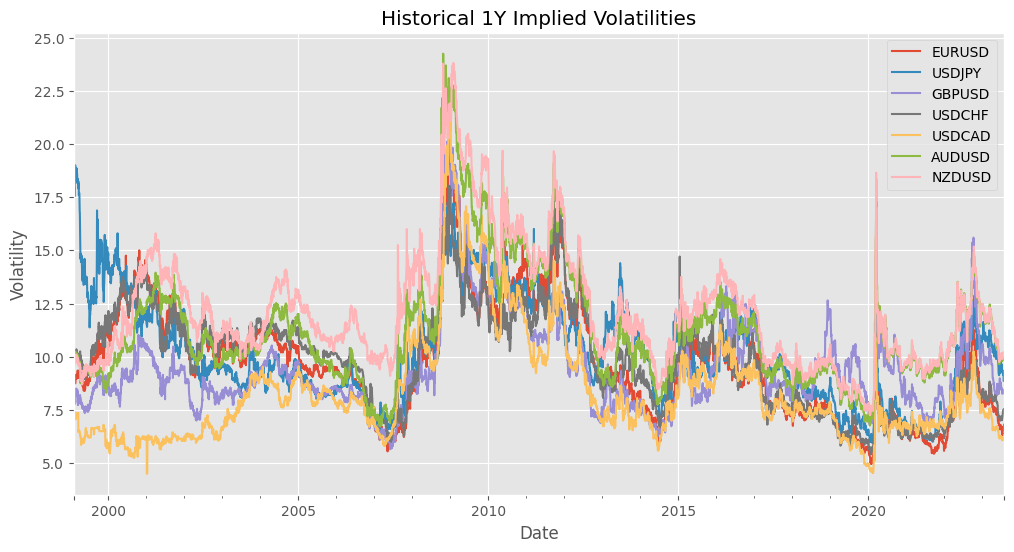

In [57]:
# Imputing the previous value when missed and droping the tail
df1y_clean = df1y.ffill().dropna()
# df1y_clean.iplot(title='Historical 1Y Implied Volatilties', xTitle='Date', yTitle='Volatility')
df1y_clean.plot(
    title="Historical 1Y Implied Volatilities",
    xlabel="Date",
    ylabel="Volatility",
    figsize=(12, 6),
)
plt.show()

For this project, I intentionally refrain from extensive data preprocessing. For example, I am not normalizing or standardizing the inputs. Firstly, for many methods, it is not necessary, and secondly, the data is already quite homogeneous. I believe the gain is rather limited, while visualization and interpretation of results could become more problematic.

Now we consider last 3 years of price history and examine the stationarity

In [58]:
idx = pd.bdate_range(
    end=df1y.index[-1], start=df1y.index[-1] + pd.tseries.offsets.DateOffset(years=-3)
)
print(
    "Timer interval from "
    + dt.datetime.strftime(idx[0].to_pydatetime(), "%Y-%m-%d")
    + " to "
    + dt.datetime.strftime(idx[-1].to_pydatetime(), "%Y-%m-%d")
)
critical_value = tableADF(len(idx), 0)[1]
print("Critial value for ADF statistics on 95% signicance level = ", critical_value)
vol_stats = pd.DataFrame(
    index=df1y.columns, columns=["ADF statistic", "Unit root", "Mean", "Std Dev"]
)
for c in df1y.columns:
    price_series = df1y_clean.loc[idx, c]
    adf = AugmentedDickeyFuller(price_series, autolag=None, maxlag=1)
    adf.fit()
    vol_stats.loc[c, ["ADF statistic", "Mean", "Std Dev"]] = (
        adf.coeff,
        price_series.mean(),
        price_series.std(),
    )
    if critical_value < adf.coeff:
        vol_stats.loc[c, "Unit root"] = "Unit root is present"
    else:
        vol_stats.loc[c, "Unit root"] = "Failed to reject unit root"
vol_stats.style.format("{:.2f}", subset=["ADF statistic", "Mean", "Std Dev"])

Timer interval from 2020-08-03 to 2023-08-01
Critial value for ADF statistics on 95% signicance level =  -2.87104


,ADF statistic,Unit root,Mean,Std Dev
EURUSD,-1.59,Unit root is present,7.30,1.38
USDJPY,-1.24,Unit root is present,8.44,1.89
GBPUSD,-2.05,Unit root is present,9.02,1.60
USDCHF,-1.63,Unit root is present,7.39,1.06
USDCAD,-2.40,Unit root is present,7.20,0.77
AUDUSD,-1.70,Unit root is present,10.68,1.37
NZDUSD,-1.78,Unit root is present,10.77,1.32


The price series are non-stationary. Now, let's take a pair as an example and conduct a cointegration analysis using Engle-Granger to determine if it is possible to formulate a mean-reverting long/short trading strategy

In [59]:
c1, c2 = "GBPUSD", "EURUSD"
s1 = df1y_clean.loc[idx, c1]
s2 = df1y_clean.loc[idx, c2]
EG = EngleGranger(s1, s2)
EG.fit()
adf_critical = tableADF(len(idx), 0)[1]
st_critical = t.ppf(0.05, len(idx) - 2)
spread = s1 - EG.coeff[1] * s2
_, mu, sigma_eq, hl = fit_uo_params(spread)
print(EG)
print("5%% signicance Critical Value for ADF test: %.2f" % adf_critical)
print("5%% significance Critical Value for ECM coefficient: %.2f" % st_critical)
print("Half-Life: %.2f" % hl)

Engle-Granger Cointegration Test
--------------------------------
Beta from naive regression: 1.05
ADF Statistic for residuals: -3.03
ECM Coefficient: -0.0262
ECM t-statistic: -3.48
5% signicance Critical Value for ADF test: -2.87
5% significance Critical Value for ECM coefficient: -1.65
Half-Life: 29.35


We see in fact that this spread can be constructed. And we can visually confirm it on the chart against the band of z-score ±2 

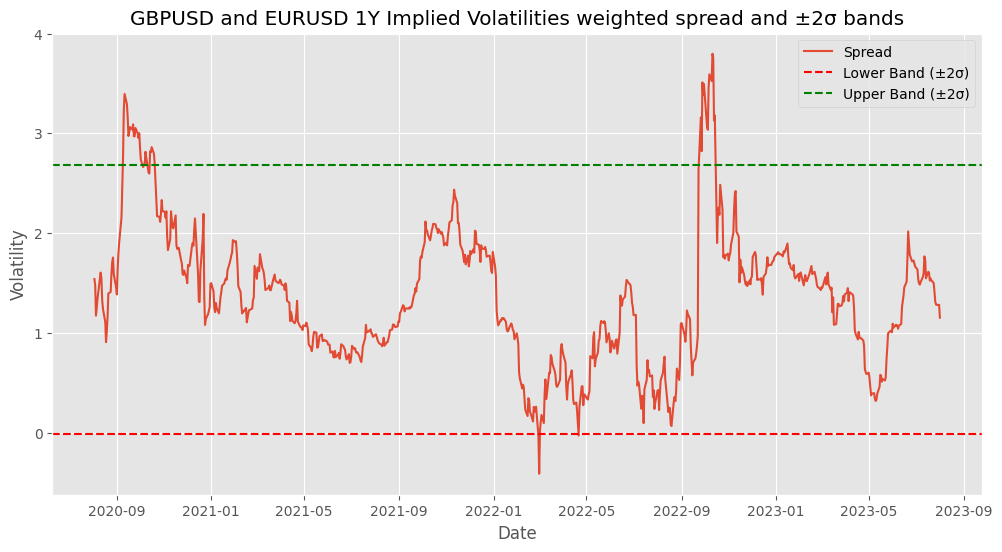

In [60]:
lb = mu - 2 * sigma_eq
ub = mu + 2 * sigma_eq

# spread.iplot(title=c1 + ' and ' + c2 + ' 1Y Implied Volatilties weighted spread and ±2σ bands',
#            xTitle='Date', yTitle='Volatility', hline=[lb, ub])
plt.figure(figsize=(12, 6))
plt.plot(spread.index, spread, label="Spread")
plt.axhline(y=lb, color="r", linestyle="--", label="Lower Band (±2σ)")
plt.axhline(y=ub, color="g", linestyle="--", label="Upper Band (±2σ)")
plt.title(f"{c1} and {c2} 1Y Implied Volatilities weighted spread and ±2σ bands")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

Of course z-score band based on in-sample data snoops ahead too much. Instead, we can try Bollinger bands

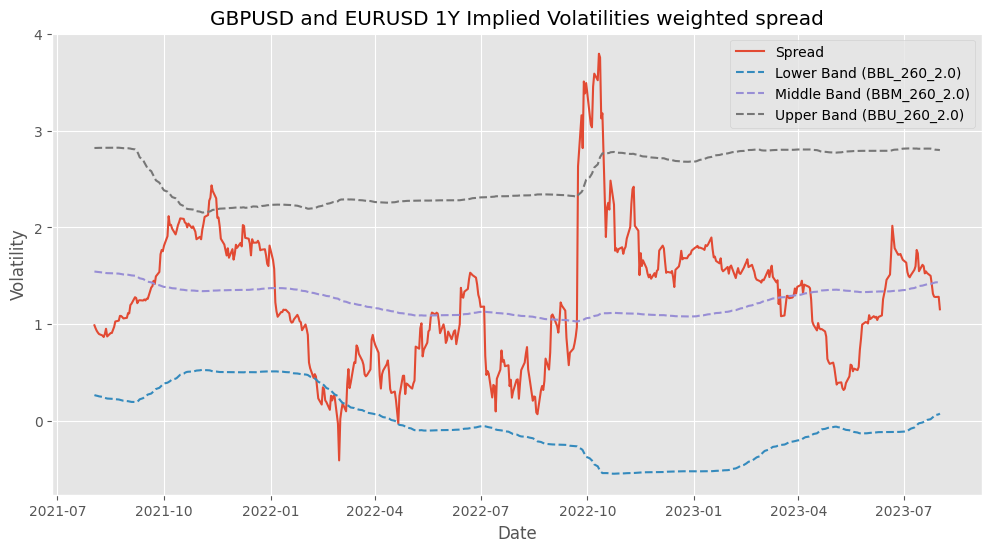

In [61]:
spread = pd.DataFrame(spread, columns=["Close"])
spread.ta.bbands(close="Close", length=260, std=2, append=True)
# spread[['Close', 'BBL_260_2.0', 'BBM_260_2.0', 'BBU_260_2.0']].iloc[260:].iplot(
#    title=c1 + ' and ' + c2 + ' 1Y Implied Volatilties weighted spread', xTitle='Date', yTitle='Volatility')
spread = spread.iloc[260:]
plt.figure(figsize=(12, 6))
plt.plot(spread.index, spread["Close"], label="Spread")
plt.plot(
    spread.index,
    spread["BBL_260_2.0"],
    linestyle="--",
    label="Lower Band (BBL_260_2.0)",
)
plt.plot(
    spread.index,
    spread["BBM_260_2.0"],
    linestyle="--",
    label="Middle Band (BBM_260_2.0)",
)
plt.plot(
    spread.index,
    spread["BBU_260_2.0"],
    linestyle="--",
    label="Upper Band (BBU_260_2.0)",
)
plt.title(f"{c1} and {c2} 1Y Implied Volatilities weighted spread")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

We see the Bollinger Bands strategy would have worked okay for this spread, although Oct 2022 would have been rather rough.

The problem with such a strategy is that almost by definition, if we plan to trade in only at the extremes, trades will occur rather rarely. Of course, we can tighten the bands and increase turnover, but it will increase transaction and opportunity costs while reducing the average expected profit per trade. The one obvious thing to do is to extend the analysis to all possible pairs and find more potential candidates

In [62]:
pairs = df1y.columns
cointegrated_portfolios = []
adf_critical = tableADF(len(idx), 0)[1]
st_critical = t.ppf(0.05, len(idx) - 2)
for i, c1 in enumerate(pairs):
    for c2 in pairs[i + 1 :]:
        # Two objects are needed to pick one with higher significance level for ecm coefficient
        EG1 = EngleGranger(df1y_clean.loc[idx, c1], df1y_clean.loc[idx, c2])
        EG1.fit()
        EG2 = EngleGranger(df1y_clean.loc[idx, c2], df1y_clean.loc[idx, c1])
        EG2.fit()
        EG = None
        if (EG1.ADFstat < adf_critical) and (EG1.ecm_tstat < st_critical):
            if (EG2.ADFstat < adf_critical) and (EG2.ecm_tstat < EG1.ecm_tstat):
                EG = EG2
                portfolio = (c2, c1)
            else:
                EG = EG1
                portfolio = (c1, c2)
        elif (EG2.ADFstat < adf_critical) and (EG2.ecm_tstat < st_critical):
            EG = EG2
            portfolio = (c2, c1)
        if EG != None:
            _, mu, sigma_eq, hl = fit_uo_params(np.array(EG.residuals + EG.coeff[0]))
            cointegrated_portfolios.append(
                [portfolio, [1, round(-EG.coeff[1], 2)], hl, mu, sigma_eq]
            )
strategies = pd.DataFrame(
    cointegrated_portfolios,
    columns=["Portfolio", "Weights", "Half-Life", "Mean", "Std"],
)
strategies.style.format("{:.2f}", subset=["Half-Life", "Mean", "Std"]).hide()

Portfolio,Weights,Half-Life,Mean,Std
"('GBPUSD', 'EURUSD')","[1, -1.05]",29.35,1.33,0.68
"('USDCAD', 'EURUSD')","[1, -0.48]",28.42,3.70,0.40
"('AUDUSD', 'EURUSD')","[1, -0.93]",17.77,3.90,0.45
"('NZDUSD', 'EURUSD')","[1, -0.89]",20.01,4.30,0.47
"('USDCHF', 'USDJPY')","[1, -0.53]",21.14,2.93,0.37
"('AUDUSD', 'USDJPY')","[1, -0.66]",29.97,5.08,0.59
"('AUDUSD', 'GBPUSD')","[1, -0.76]",27.76,3.87,0.61
"('NZDUSD', 'GBPUSD')","[1, -0.74]",25.55,4.16,0.58
"('AUDUSD', 'USDCHF')","[1, -1.24]",12.93,1.53,0.38
"('NZDUSD', 'USDCHF')","[1, -1.19]",14.58,2.00,0.40


Now we have a menu of long/short strategies that exhibit mean-reversion. But there is still more we can get from the data if
we go beyond pairs and perform a multivariate cointegration analysis.

To be able to construct integrating portfolios of more than two assets we can use Johansen procedure. Here's an example utilising python library statsmodels

In [63]:
idx = pd.bdate_range(
    end=df1y.index[-1], start=df1y.index[-1] + pd.tseries.offsets.DateOffset(years=-3)
)
demo_df = df1y_clean.loc[idx]
demo_df.to_csv("sample.csv")
res = coint_johansen(demo_df, det_order=1, k_ar_diff=1)
print("Currencies:", np.array(demo_df.columns))
print("Time period:", demo_df.index[0], "to ", demo_df.index[-1])
with np.printoptions(precision=4, suppress=True, linewidth=100, threshold=10000):
    print("Eigenvalues:\n", res.eig)
    print("Eigevectors normilized to first column")
    print((res.evec / res.evec[0, :]))
    print("Test statistics for eigevalues test: \n", res.lr2)
    print("Critical values for eigenvalues test: \n", res.cvm)
    print("Test statistics for trace test: \n", res.lr1)
    print("Critical values for trace test: \n", res.cvt)

Currencies: ['EURUSD' 'USDJPY' 'GBPUSD' 'USDCHF' 'USDCAD' 'AUDUSD' 'NZDUSD']
Time period: 2020-08-03 00:00:00 to  2023-08-01 00:00:00
Eigenvalues:
 [0.0866 0.0649 0.0443 0.0252 0.0208 0.0107 0.0038]
Eigevectors normilized to first column
[[ 1.      1.      1.      1.      1.      1.      1.    ]
 [ 0.0202 -3.43    2.5834 -0.143   0.35   -0.6053  0.546 ]
 [-0.4456  0.1934 -0.9392  0.5599 -0.3522 -0.5053 -0.0348]
 [-0.5242 -2.0188 -6.9254 -1.7382 -0.8935 -0.4097 -0.9659]
 [-0.8533 -5.066   1.8173 -0.0784 -0.1609  0.8571 -0.4142]
 [-3.3825 10.654  -1.3359 -0.3075  2.6343 -0.3816  2.0392]
 [ 3.8922 -4.3847  2.8762 -0.0299 -3.0803  0.4514 -1.0512]]
Test statistics for eigevalues test: 
 [70.6926 52.3034 35.3674 19.9316 16.3988  8.3634  2.9623]
Critical values for eigenvalues test: 
 [[46.5583 49.5875 55.8171]
 [40.5244 43.4183 49.4095]
 [34.4202 37.1646 42.8612]
 [28.2398 30.8151 36.193 ]
 [21.8731 24.2522 29.2631]
 [15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]]
Test statistics for t

For the purposes of validation below is the output of same Johansen procedure realised in urca package in R (notebook attached)

In [ ]:
"""
###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend in cointegration 

Eigenvalues (lambda):
[1] 8.681531e-02 6.491141e-02 4.498019e-02 2.524265e-02 2.093684e-02
[6] 1.115009e-02 3.838508e-03 1.058603e-19

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 6 |  3.00 10.49 12.25 16.26
r <= 5 |  8.75 16.85 18.96 23.65
r <= 4 | 16.50 23.11 25.54 30.34
r <= 3 | 19.94 29.12 31.46 36.65
r <= 2 | 35.90 34.75 37.52 42.36
r <= 1 | 52.35 40.91 43.97 49.51
r = 0  | 70.84 46.32 49.42 54.71

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              EURUSD.l1    USDJPY.l1    GBPUSD.l1    USDCHF.l1     USDCAD.l1
EURUSD.l1  1.0000000000  1.000000000  1.000000000  1.000000000  1.0000000000
USDJPY.l1  0.0207768779 -3.308560787  2.529184122 -0.133789585  0.3862586788
GBPUSD.l1 -0.4452429768  0.168826928 -0.944150839  0.554988453 -0.3649242158
USDCHF.l1 -0.5168014916 -2.016251559 -6.701254951 -1.749746487 -0.9406498998
USDCAD.l1 -0.8529661238 -4.917172821  1.787756635 -0.076789693 -0.1610919147
AUDUSD.l1 -3.3933295094 10.227332608 -1.646689862 -0.277973496  2.7530897365
NZDUSD.l1  3.8967157329 -4.123881048  3.118771307 -0.057159865 -3.1948383164
trend.l1  -0.0009139176  0.008054423 -0.002876728  0.002882231 -0.0006208891
             AUDUSD.l1    NZDUSD.l1    trend.l1
EURUSD.l1  1.000000000  1.000000000  1.00000000
USDJPY.l1 -0.584194188  0.599061522 -0.12121190
GBPUSD.l1 -0.477917502  0.009137399 -1.00067511
USDCHF.l1 -0.341291927 -0.896297870 -3.66759988
USDCAD.l1  0.758080316 -0.562074994  3.14676486
AUDUSD.l1 -0.332166724  2.130305915  1.55032367
NZDUSD.l1  0.350012538 -1.159317619  0.60478400
trend.l1   0.002779736 -0.006260931 -0.03102493

Weights W:
(This is the loading matrix)

            EURUSD.l1    USDJPY.l1    GBPUSD.l1    USDCHF.l1   USDCAD.l1
EURUSD.d -0.024815011 -0.001814062  0.004801192 -0.007149011 0.016272311
USDJPY.d -0.017587072  0.005780029 -0.005553754  0.013455230 0.007856729
GBPUSD.d  0.049180103 -0.008215842  0.003300531 -0.015434050 0.028860202
USDCHF.d -0.007355715 -0.001165697  0.007172014  0.008912249 0.012091008
USDCAD.d  0.033490474 -0.004382338 -0.004305310  0.006654707 0.015691150
AUDUSD.d -0.004061438 -0.016636403 -0.002835407  0.010884921 0.009490065
NZDUSD.d -0.028707090 -0.014768301 -0.003930218  0.012517206 0.015111040
             AUDUSD.l1    NZDUSD.l1      trend.l1
EURUSD.d -0.0011319541 -0.003675070 -1.746001e-16
USDJPY.d  0.0127064706 -0.003730429 -2.571902e-16
GBPUSD.d  0.0111150365 -0.002067616  3.587586e-16
USDCHF.d  0.0006710432 -0.002411493 -3.654559e-17
USDCAD.d -0.0025956171 -0.002483430  2.418684e-16
AUDUSD.d  0.0030976156 -0.003101983  2.922343e-16
NZDUSD.d  0.0027200313 -0.002436642  6.585911e-17


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend in cointegration 

Eigenvalues (lambda):
[1] 8.681531e-02 6.491141e-02 4.498019e-02 2.524265e-02 2.093684e-02
[6] 1.115009e-02 3.838508e-03 1.058603e-19

Values of teststatistic and critical values of test:

           test  10pct   5pct   1pct
r <= 6 |   3.00  10.49  12.25  16.26
r <= 5 |  11.75  22.76  25.32  30.45
r <= 4 |  28.25  39.06  42.44  48.45
r <= 3 |  48.19  59.14  62.99  70.05
r <= 2 |  84.09  83.20  87.31  96.58
r <= 1 | 136.44 110.42 114.90 124.75
r = 0  | 207.28 141.01 146.76 158.49

Eigenvectors, normalised to first column:
(These are the cointegration relations)

              EURUSD.l1    USDJPY.l1    GBPUSD.l1    USDCHF.l1     USDCAD.l1
EURUSD.l1  1.0000000000  1.000000000  1.000000000  1.000000000  1.0000000000
USDJPY.l1  0.0207768779 -3.308560787  2.529184122 -0.133789585  0.3862586788
GBPUSD.l1 -0.4452429768  0.168826928 -0.944150839  0.554988453 -0.3649242158
USDCHF.l1 -0.5168014916 -2.016251559 -6.701254951 -1.749746487 -0.9406498998
USDCAD.l1 -0.8529661238 -4.917172821  1.787756635 -0.076789693 -0.1610919147
AUDUSD.l1 -3.3933295094 10.227332608 -1.646689862 -0.277973496  2.7530897365
NZDUSD.l1  3.8967157329 -4.123881048  3.118771307 -0.057159865 -3.1948383164
trend.l1  -0.0009139176  0.008054423 -0.002876728  0.002882231 -0.0006208891
             AUDUSD.l1    NZDUSD.l1    trend.l1
EURUSD.l1  1.000000000  1.000000000  1.00000000
USDJPY.l1 -0.584194188  0.599061522 -0.12121190
GBPUSD.l1 -0.477917502  0.009137399 -1.00067511
USDCHF.l1 -0.341291927 -0.896297870 -3.66759988
USDCAD.l1  0.758080316 -0.562074994  3.14676486
AUDUSD.l1 -0.332166724  2.130305915  1.55032367
NZDUSD.l1  0.350012538 -1.159317619  0.60478400
trend.l1   0.002779736 -0.006260931 -0.03102493

Weights W:
(This is the loading matrix)

            EURUSD.l1    USDJPY.l1    GBPUSD.l1    USDCHF.l1   USDCAD.l1
EURUSD.d -0.024815011 -0.001814062  0.004801192 -0.007149011 0.016272311
USDJPY.d -0.017587072  0.005780029 -0.005553754  0.013455230 0.007856729
GBPUSD.d  0.049180103 -0.008215842  0.003300531 -0.015434050 0.028860202
USDCHF.d -0.007355715 -0.001165697  0.007172014  0.008912249 0.012091008
USDCAD.d  0.033490474 -0.004382338 -0.004305310  0.006654707 0.015691150
AUDUSD.d -0.004061438 -0.016636403 -0.002835407  0.010884921 0.009490065
NZDUSD.d -0.028707090 -0.014768301 -0.003930218  0.012517206 0.015111040
             AUDUSD.l1    NZDUSD.l1      trend.l1
EURUSD.d -0.0011319541 -0.003675070 -1.746001e-16
USDJPY.d  0.0127064706 -0.003730429 -2.571902e-16
GBPUSD.d  0.0111150365 -0.002067616  3.587586e-16
USDCHF.d  0.0006710432 -0.002411493 -3.654559e-17
USDCAD.d -0.0025956171 -0.002483430  2.418684e-16
AUDUSD.d  0.0030976156 -0.003101983  2.922343e-16
NZDUSD.d  0.0027200313 -0.002436642  6.585911e-17

"""

It takes some time to reconcile the differences in notations and inputs between the two implementations, but in the end, I find the results to be rather similar. We can observe that the test statistics and eigenvectors are very close, but there is a mismatch between the critical values. To assess the practical significance of this mismatch, I will apply both implementations to all possible triplets and compare the outcomes.

Here is an example of identifying cointegrating triplets with the Johansen method in Python:

In [64]:
pairs = df1y.columns
cointegrated_portfolios = []
for i, c1 in enumerate(pairs):
    for j, c2 in enumerate(pairs[i + 1 :]):
        for c3 in pairs[i + j + 2 :]:
            data = df1y_clean.loc[idx, [c1, c2, c3]]
            res = coint_johansen(data, det_order=1, k_ar_diff=1)
            for d in range(3):
                if (res.lr2[d] > res.cvm[d, 1]) and (res.lr1[d] > res.cvt[d, 1]):
                    vec_norm = res.evec[:, d] / res.evec[0, d]
                    portfolio_value = np.array(data.dot(vec_norm))
                    _, mu, sigma_eq, hl = fit_uo_params(portfolio_value)
                    cointegrated_portfolios.append(
                        [(c1, c2, c3), vec_norm, hl, mu, sigma_eq]
                    )
                else:
                    break
strategies = pd.DataFrame(
    cointegrated_portfolios,
    columns=["Portfolio", "Weights", "Half-Life", "Mean", "Std"],
)
strategies.style.format("{:.2f}", subset=["Half-Life", "Mean", "Std"]).hide()

Portfolio,Weights,Half-Life,Mean,Std
"('EURUSD', 'USDJPY', 'USDCHF')",[ 1. 0.62883912 -2.44361362],13.37,-5.45,0.46
"('EURUSD', 'USDJPY', 'USDCAD')",[ 1. -0.54304003 -0.93017432],21.64,-4.02,0.50
"('EURUSD', 'USDCHF', 'AUDUSD')",[ 1. -5.55530068 2.88764491],17.53,-2.98,1.49
"('EURUSD', 'USDCHF', 'NZDUSD')",[ 1. -3.83089927 1.73067735],20.82,-2.42,1.03
"('EURUSD', 'USDCAD', 'AUDUSD')",[ 1. -0.2818964 -0.93364603],17.75,-4.71,0.47
"('EURUSD', 'USDCAD', 'AUDUSD')",[ 1. 16.76726378 -10.47768623],36.34,15.74,6.96
"('EURUSD', 'AUDUSD', 'NZDUSD')",[ 1. -5.73041416 4.89752751],5.73,-1.12,0.56
"('EURUSD', 'AUDUSD', 'NZDUSD')",[ 1. 2.82804845 -4.11049594],15.63,-6.81,0.74
"('USDJPY', 'USDCHF', 'USDCAD')",[ 1. -2.30603347 1.1074127 ],10.53,-0.61,0.58
"('USDJPY', 'USDCHF', 'AUDUSD')",[ 1. -9.06704203 5.41944456],11.73,-0.69,2.33


Calculation of the same table is availbale in separate R notebook. The results are:

In [65]:
pd.read_csv("test.csv", index_col=0).style.format(
    "{:.2f}", subset=["HL", "Mean", "Std"]
).hide()

Portfolio,Weights,HL,Mean,Std
"EURUSD, USDCHF, AUDUSD","1, -5.57972167393135, 2.90534678414481",17.50,-2.97,1.50
"EURUSD, USDCHF, NZDUSD","1, -3.86151447053565, 1.75356040495089",20.74,-2.40,1.04
"EURUSD, USDCAD, AUDUSD","1, -0.322187843980548, -0.911044455685978",17.80,-4.76,0.47
"EURUSD, AUDUSD, NZDUSD","1, -5.70484433524699, 4.87063874545255",5.75,-1.14,0.56
"USDJPY, USDCHF, USDCAD","1, -2.32008973886651, 1.12540474169002",10.49,-0.58,0.58
"USDJPY, USDCHF, AUDUSD","1, -9.27351337406553, 5.56592881957701",11.76,-0.66,2.39
"USDJPY, USDCHF, NZDUSD","1, -5.14451219765323, 2.73772191673321",11.92,-0.06,1.32
"USDJPY, USDCAD, AUDUSD","1, 1.57019378626998, -1.8964581597152",10.69,-0.48,0.58
"USDJPY, USDCAD, NZDUSD","1, 1.86873556171752, -2.1500013853689",9.92,-1.25,0.62
"USDJPY, AUDUSD, NZDUSD","1, -7.54872514135642, 6.82773958457637",11.09,1.44,1.03


As expected, since the critical values used in urca are generally higher, the R implementation returns slightly fewer cointegrated relationships at the 95% significance level. Due to the exotic distributions of test statistics in the Johansen test, it is challenging to determine which (if any) critical values are correct. However, I reproduced the calculations of the Johansen test in Python from the book 'Algorithmic Trading' by Ernest Chan. The critical values in Ernie's example, obtained in Matlab, matched exactly with the values in Python.

I've covered the topics of cointegration analysis and Ornstein-Uhlenbeck fitting. These techniques help us identify mean-reverting market portfolios with favorable properties. Now, the question is, how do we trade them? Our edge lies in buying the portfolio below its mean price ($\mu_e$) level and selling it above. However, we don't want to execute trades at any level of deviation, as the signal is too weak when close to the mean.

The simplest approach is to enter a position when the price crosses some fixed band $\mu_e ± Z\sigma_{eq}$ and exit when it reverts back to $\mu_e$. In practice, people may use techniques such as smooth scaling-in, multiple bands, price or time stop-losses, etc. For this illustration, I'll show what happens when we make our trading strategy more (or less) aggressive.

I'll consider an example cointegrated portfolio obtained using the Johansen procedure mentioned earlier. For each value in the vector of Z-scores {0.5, 0.6, ..., 2.9, 3.0}, used as a symmetrical trading bound, we can calculate accumulated gross and net P&L (assuming some transaction costs) along with some other useful statistics.

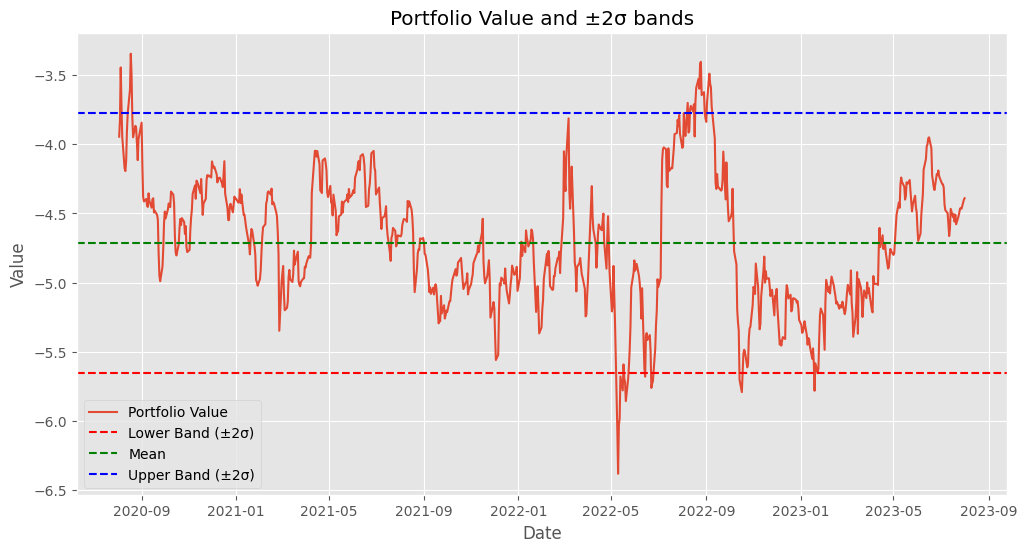

Bands Z-score,Gross Performance,Net Performance,Number of Trades,Annualised Std Dev
0.50,9.28,0.64,39,1.9299
0.60,9.68,1.48,37,1.9106
0.70,9.38,2.07,33,1.8858
0.80,9.28,2.85,29,1.8555
0.90,8.48,2.94,25,1.8435
1.00,8.52,2.98,25,1.8366
1.10,9.00,3.46,25,1.7985
1.20,8.56,3.46,23,1.7763
1.30,8.38,4.17,19,1.6821
1.40,6.91,3.59,15,1.5974


In [66]:
portfolio, weights = strategies.iloc[4][["Portfolio", "Weights"]]
mu, sigma_eq = strategies.iloc[4][["Mean", "Std"]]
lb, mb, ub = (mu - 2 * sigma_eq, mu, mu + 2 * sigma_eq)
portfolio_value = df1y_clean.loc[idx, portfolio].dot(weights)
# portfolio_value.iplot(title='Portfolio Value and ±2σ bands', xTitle='Date', yTitle='Value',
#                                                hline=[lb, mb, ub])
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value.index, portfolio_value, label="Portfolio Value")
plt.axhline(y=lb, color="r", linestyle="--", label="Lower Band (±2σ)")
plt.axhline(y=mb, color="g", linestyle="--", label="Mean")
plt.axhline(y=ub, color="b", linestyle="--", label="Upper Band (±2σ)")
plt.title("Portfolio Value and ±2σ bands")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()
zscores = pd.DataFrame(
    index=np.linspace(0.5, 3, 26),
    columns=["Gross Performance", "Annualised Std Dev", "Number of Trades"],
)
for z in zscores.index:
    lb, mb, ub = (mu - z * sigma_eq, mu, mu + z * sigma_eq)
    position = np.where(
        portfolio_value <= lb, 1, np.where(portfolio_value >= ub, -1, 0)
    )
    for i in range(1, len(idx)):
        if (portfolio_value.iloc[i] < mb) and (position[i - 1] == 1):
            position[i] = 1
        if (portfolio_value.iloc[i] > mb) and (position[i - 1] == -1):
            position[i] = -1
    trading = pd.DataFrame(position, index=idx, columns=["Position"])
    trading["Trades"] = trading["Position"].diff()
    trading["Trades"].iloc[0] = trading["Position"].iloc[0]
    trading["Daily Performance"] = trading["Position"].shift() * portfolio_value.diff()
    trading["Cumulative Performance"] = trading["Daily Performance"].cumsum()
    zscores.loc[z] = [
        trading["Cumulative Performance"].iloc[-1],
        sqrt(260) * trading["Daily Performance"].std(),
        trading["Trades"].abs().sum(),
    ]
trade_cost = sum(abs(weights)) * 0.1
zscores["Net Performance"] = (
    zscores["Gross Performance"] - trade_cost * zscores["Number of Trades"]
)

zscores[
    ["Gross Performance", "Net Performance", "Number of Trades", "Annualised Std Dev"]
].rename_axis("Bands Z-score").reset_index().style.hide().format(
    {
        "Gross Performance": "{:.2f}",
        "Annualised Std Dev": "{:.4f}",
        "Number of Trades": "{:.0f}",
        "Net Performance": "{:.2f}",
        "Bands Z-score": "{:.2f}",
    }
)

The first observation is that generally, but not strictly, tighter bounds produce higher accumulated gross P&L. Sometimes, when we widen the band, gross P&L increases because we capture the same price moves at better levels. However, in general, a tighter band means more trades, and as they have a positive expectancy, it translates to more profits.

When we start considering costs and risks, the situation is different. When $Z$ is too small, transaction costs can erode almost all profit. At the same time, a tighter bound means the proportion of time that the strategy holds a position is higher. This implies that the volatility of daily P&L is higher.

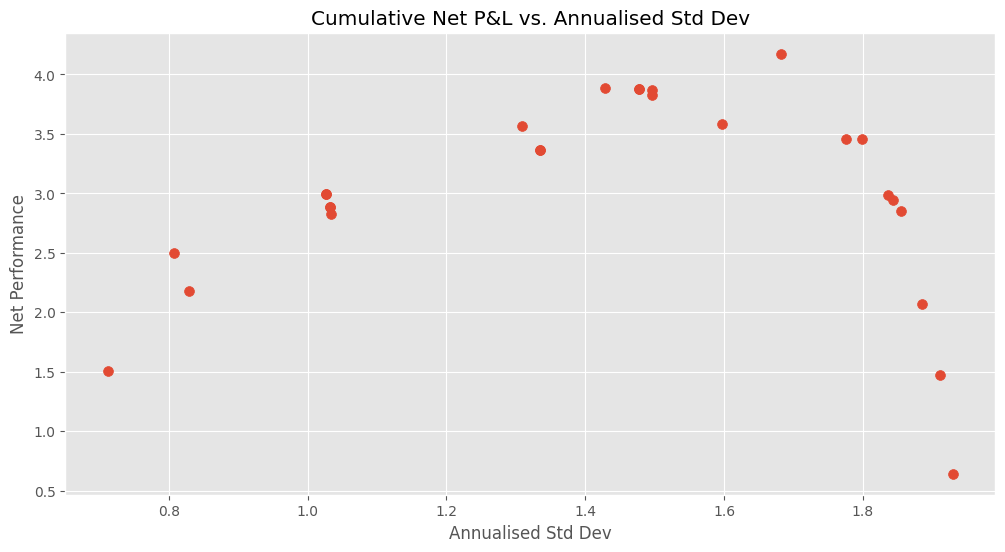

In [67]:
# zscores.iplot(kind='scatter', x='Annualised Std Dev', y='Net Performance', mode='markers', size=10,
#            title='Cummulative Net P&L vs. Annualised Std Dev', xTitle='Annualised Std Dev', yTitle='Net Performance')
plt.figure(figsize=(12, 6))
plt.scatter(zscores["Annualised Std Dev"], zscores["Net Performance"], s=50)
plt.title("Cumulative Net P&L vs. Annualised Std Dev")
plt.xlabel("Annualised Std Dev")
plt.ylabel("Net Performance")
plt.grid(True)
plt.show()

In the chart above, we can roughly observe the shape of the frontier, allowing the trader to decide on which part of it to focus. For example, if the goal is to maximize net P&L, one might choose a band close to $1.3\sigma_{eq}$. It's also possible to calculate more risk metrics from the data, such as expected drawdown, tail ratio, etc. Additionally, we can optimize the trading strategy to maximize the Sharpe Ratio or something more sophisticated.

It's important to note that the calculations above were made in-sample for illustration purposes. If we genuinely want to optimize with respect to $Z$ (or any other parameter), we will need to set aside a portion of the data for a validation set and ensure we didn't use it for cointegration analysis. For practitioners, it is dangerous to consider in-sample variance estimation based on the above (or, for example, conditional variance based on a fitted OU process) as a true measure of risk. The main risks of such strategies come from factors like structural breaks, regime changes, cointegration breakdown, hedge ratios changing, etc. Simply by the design of cointegration analysis procedures, the considered portfolios did not experience such events in-sample. That, of course, does not mean that such things cannot occur in live trading. Finally, as we are restricted by the dataset, we face a trade-off between obtaining better estimates of cointegrating parameters and obtaining better trading and risk parameters.

## Closer look at the data

Above, I delved into a discussion about what a trading strategy may look like. Still, the analysis was mostly describing the data rather than proposing a viable strategy. I aim to close that gap.

But first, I suggest that instead of having a solution (cointegration analysis) in search of a problem, we better start with the problem itself. We need to examine the market data and explore its properties and how they can be exploited.

Over a long enough horizon, many implied volatilities are close to being stationary. Here, I run the unit root test again for 20 years of data.

In [68]:
idx = pd.bdate_range(
    end=df1y.index[-1], start=df1y.index[-1] + pd.tseries.offsets.DateOffset(years=-20)
)
critical_value = tableADF(len(idx), 0)[1]
print(
    "Timer interval from "
    + dt.datetime.strftime(idx[0].to_pydatetime(), "%Y-%m-%d")
    + " to "
    + dt.datetime.strftime(idx[-1].to_pydatetime(), "%Y-%m-%d")
)
print("Critial value for ADF statistics on 95%% signicance level = ", critical_value)
vol_stats = pd.DataFrame(
    index=df1y.columns, columns=["ADF statistic", "Unit root", "Mean", "Std Dev"]
)
for c in df1y.columns:
    price_series = df1y_clean.loc[idx, c]
    adf = AugmentedDickeyFuller(price_series, autolag=None, maxlag=1)
    adf.fit()
    vol_stats.loc[c, ["ADF statistic", "Mean", "Std Dev"]] = (
        adf.coeff,
        price_series.mean(),
        price_series.std(),
    )
    if critical_value < adf.coeff:
        vol_stats.loc[c, "Unit root"] = "Unit root is present"
    else:
        vol_stats.loc[c, "Unit root"] = "Failed to reject unit root"
vol_stats.style.format("{:.2f}", subset=["ADF statistic", "Mean", "Std Dev"])

Timer interval from 2003-08-01 to 2023-08-01
Critial value for ADF statistics on 95%% signicance level =  -2.87104


,ADF statistic,Unit root,Mean,Std Dev
EURUSD,-2.51,Unit root is present,9.44,2.74
USDJPY,-3.30,Failed to reject unit root,9.87,2.31
GBPUSD,-3.23,Failed to reject unit root,9.62,2.39
USDCHF,-2.97,Failed to reject unit root,9.58,2.44
USDCAD,-2.49,Unit root is present,8.83,2.64
AUDUSD,-2.82,Unit root is present,11.40,3.00
NZDUSD,-3.10,Failed to reject unit root,12.22,2.93


Unit root presence is rejected for more than half of currencies and the rest are not far from it. However, a simple look at the chart
tells us that this observation is not too helpful for trading.

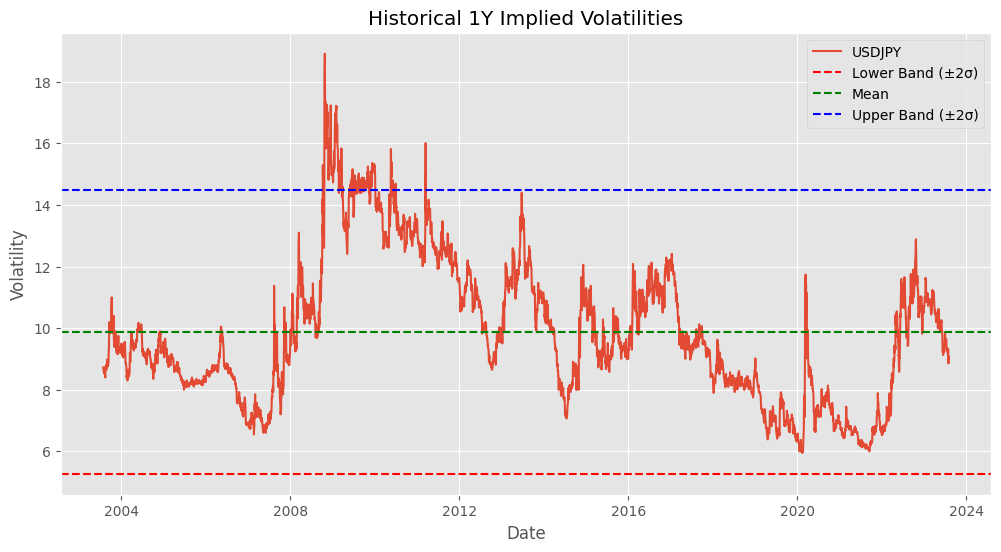

Mean: 9.88 Std Dev: 2.30 Half-Life: 171.40


In [69]:
_, mu, sigma_eq, hl = fit_uo_params(df1y_clean.loc[idx, "USDJPY"])
lb, mb, ub = (mu - 2 * sigma_eq, mu, mu + 2 * sigma_eq)
# df1y_clean.loc[idx, 'USDJPY'].iplot(title='Historical 1Y Implied Volatilties', xTitle='Date', yTitle='Volatility',
#                                    hline=[lb, mb, ub])
plt.figure(figsize=(12, 6))
plt.plot(df1y_clean.loc[idx, "USDJPY"], label="USDJPY")
plt.axhline(y=lb, color="r", linestyle="--", label="Lower Band (±2σ)")
plt.axhline(y=mb, color="g", linestyle="--", label="Mean")
plt.axhline(y=ub, color="b", linestyle="--", label="Upper Band (±2σ)")
plt.title("Historical 1Y Implied Volatilities")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()
print("Mean: %.2f Std Dev: %.2f Half-Life: %.2f" % (mu, sigma_eq, hl))

Firstly, the Ornstein-Uhlenbeck model is not the best fit for outright implied volatility. Even if it were, the half-life would likely deter us. The implied volatility distribution is both skewed and fat-tailed, so if we don't want to spend multiple years without making a single trade, we'll have to tighten the trading bounds. However, when we do that, the potential drawdown becomes enormous, especially on the short vol side.

Another avenue to explore is utilizing several stationary time series, which opens up a broader econometric toolkit for forecasting. One promising approach is to use a sophisticated Vector Auto Regression (VAR(p)). Without delving too much into the details here to stay focused on the project's topic, I'll mention that, in short, the signals produced by it are often too weak and hardly have any practical use. This suggests that we need to try something else.

We know that we can use Principal Component Analysis to gain insights about a collection of closely related variables.

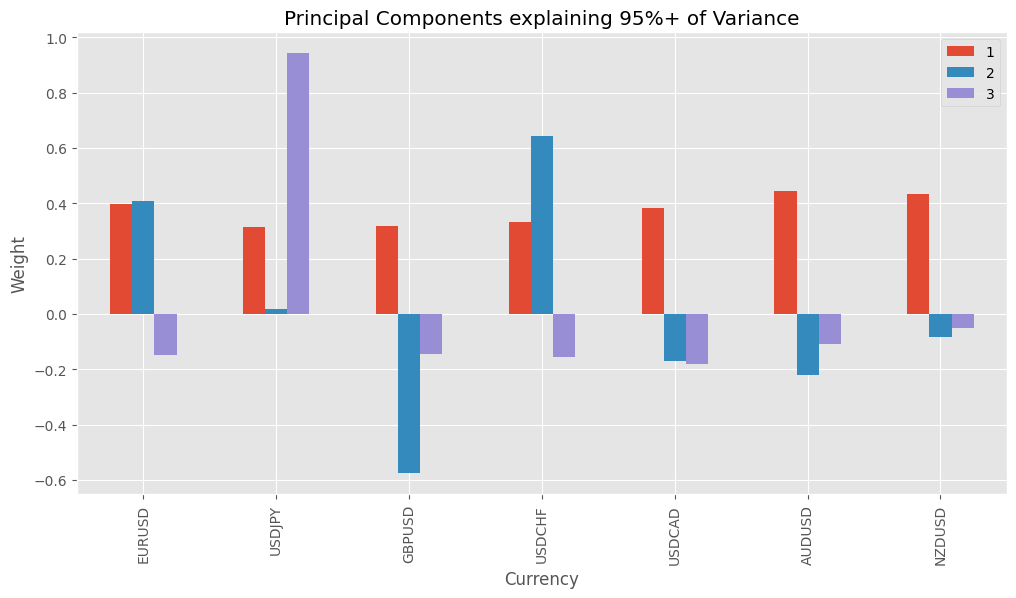

In [70]:
idx = pd.bdate_range(
    end=df1y.index[-1], start=df1y.index[-1] + pd.tseries.offsets.DateOffset(years=-20)
)
myPCA = PCA()
myPCA.fit(df1y_clean.loc[idx])
i = 0
while myPCA.explained_variance_ratio_.cumsum()[i] < 0.95:
    i += 1
principal_components = pd.DataFrame(
    columns=list(range(1, i + 2, 1)),
    index=df1y.columns,
    data=myPCA.components_[: i + 1].T,
)
# principal_components.iplot(kind='bar', title='Principal Components explaining 95%+ of Variance', xTitle='Currency', yTitle='Weight')
principal_components.plot(
    kind="bar",
    title="Principal Components explaining 95%+ of Variance",
    xlabel="Currency",
    ylabel="Weight",
    figsize=(12, 6),
)
plt.show()
factors = pd.DataFrame(data=myPCA.fit_transform(df1y_clean.loc[idx]), index=idx)

We observe that 95% of the variance is explained by three components.

The interpretation of the first one is straightforward; it represents the market price of FX vol as a factor. This factor is positive for all currencies, with, for example, higher values in AUDUSD than in USDJPY. In other words, AUDUSD vol has a higher market beta than USDJPY. The entire vector can be understood as a multivariate beta.

Interpreting the second vector, we find that it resembles the factor of relative value between safe-haven currencies versus risky currencies, although it's unusually flat in JPY. It may not be as perfectly clean as the first factor, but the market is definitely conveying some information with it.

Lastly, the third vector appears to be very idiosyncratic, representing USDJPY versus everything else. Based on these observations, we can say that the market for G10 currencies' implied volatilities can be modeled with two factors, some idiosyncrasies, and a lot of noise.

As we are in search of trade opportunities, we now want to examine the behavior of residuals obtained after reducing dimensions to 2 with PCA.

Critial value for ADF statistics on 95% signicance level = -2.87
ADF Statistic: -5.72 Mean: -0.01 Std Dev: 0.46 Half-Life: 50.56


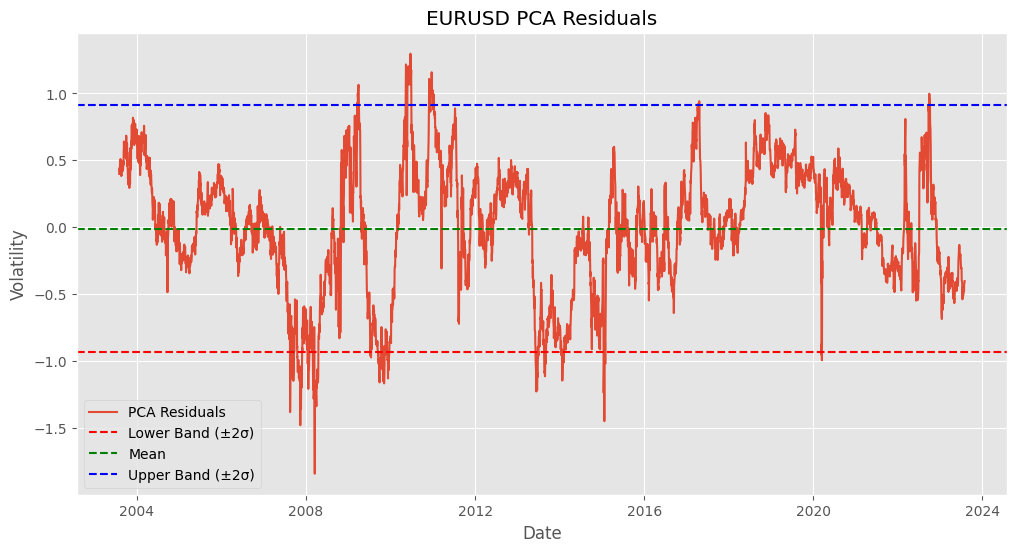

ADF Statistic: -5.16 Mean: 0.03 Std Dev: 1.01 Half-Life: 68.66


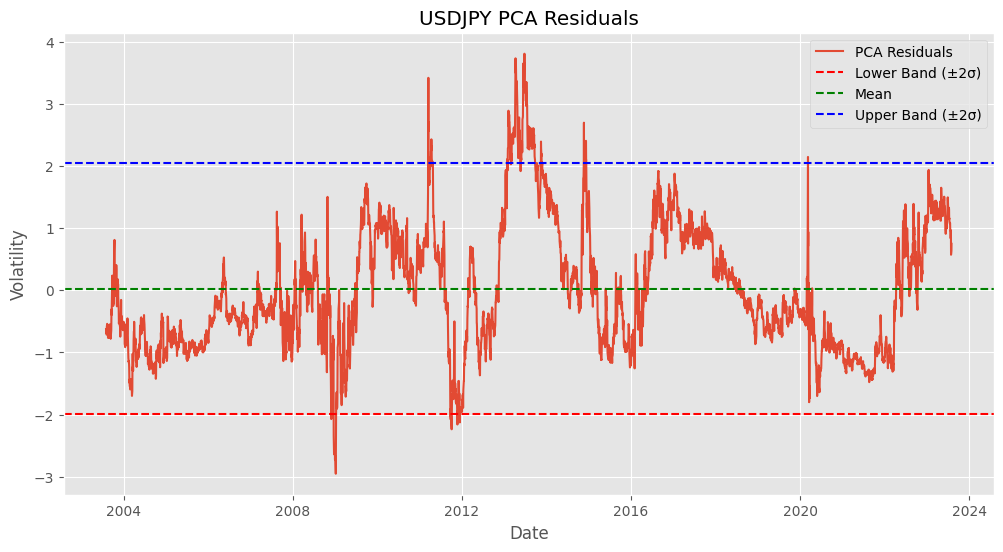

ADF Statistic: -6.55 Mean: -0.01 Std Dev: 0.71 Half-Life: 45.47


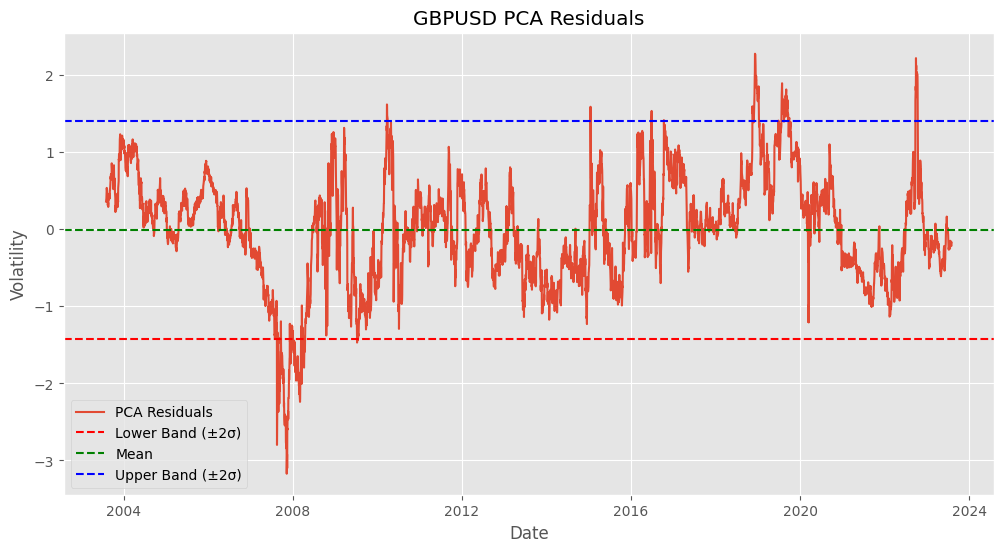

ADF Statistic: -7.04 Mean: -0.00 Std Dev: 0.33 Half-Life: 35.81


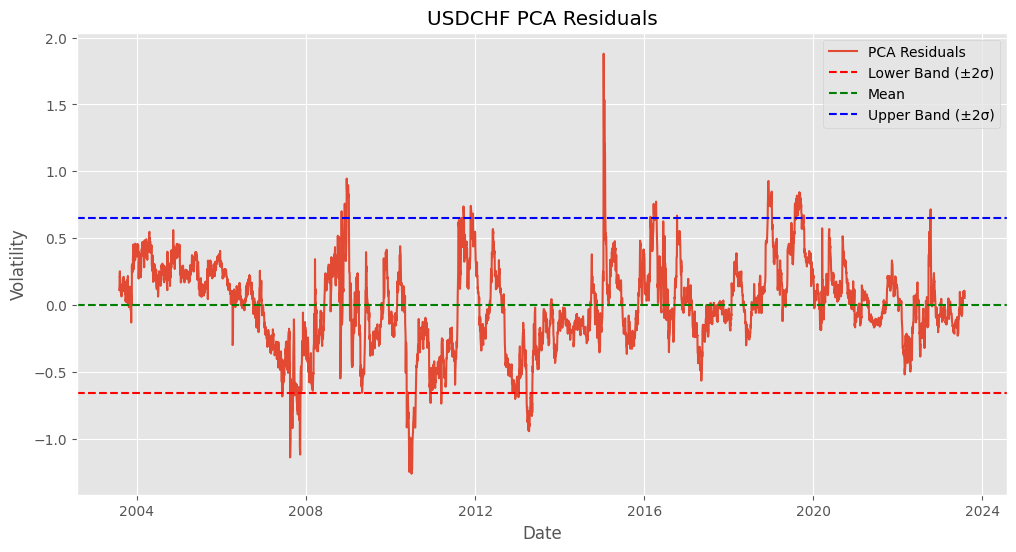

ADF Statistic: -5.70 Mean: -0.02 Std Dev: 0.69 Half-Life: 52.17


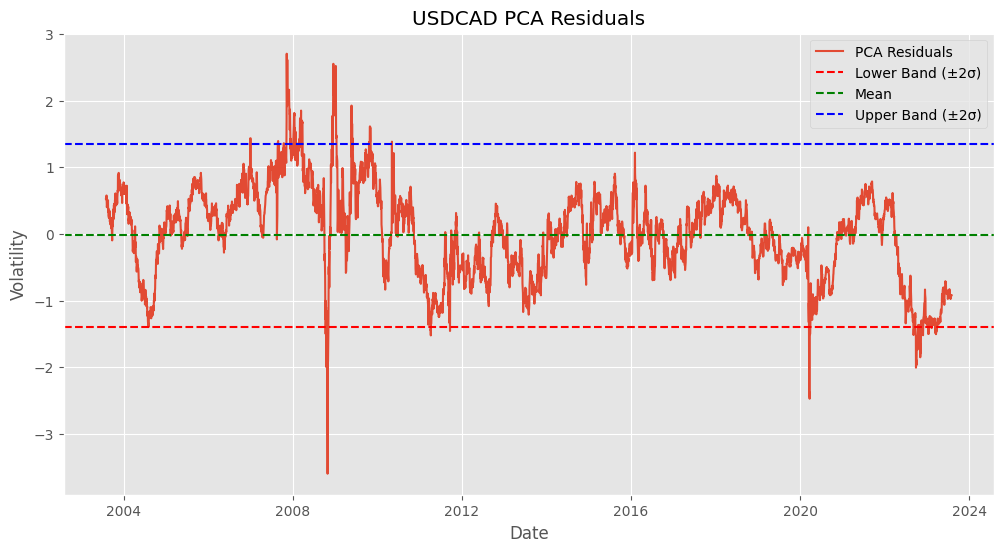

ADF Statistic: -5.54 Mean: 0.01 Std Dev: 0.56 Half-Life: 47.38


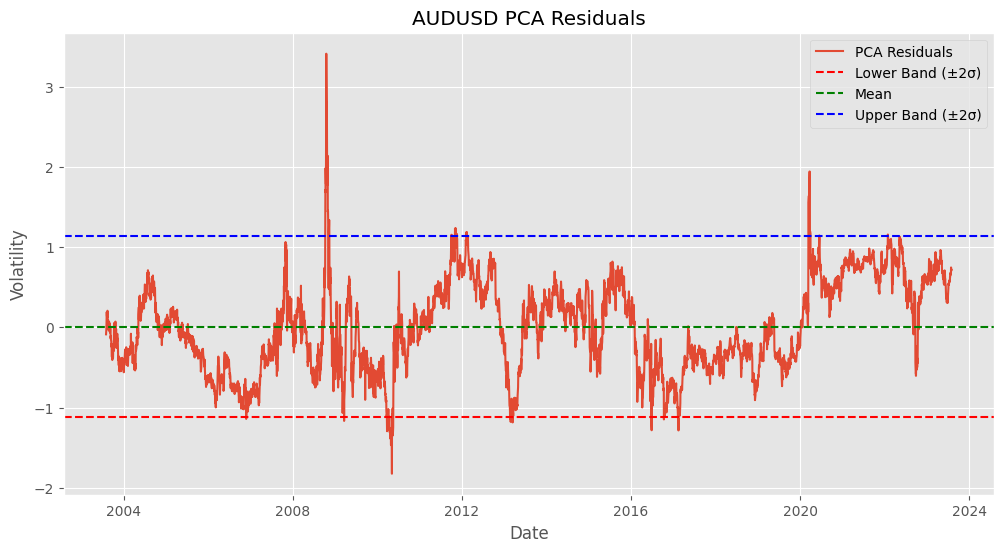

ADF Statistic: -6.91 Mean: 0.01 Std Dev: 0.61 Half-Life: 31.30


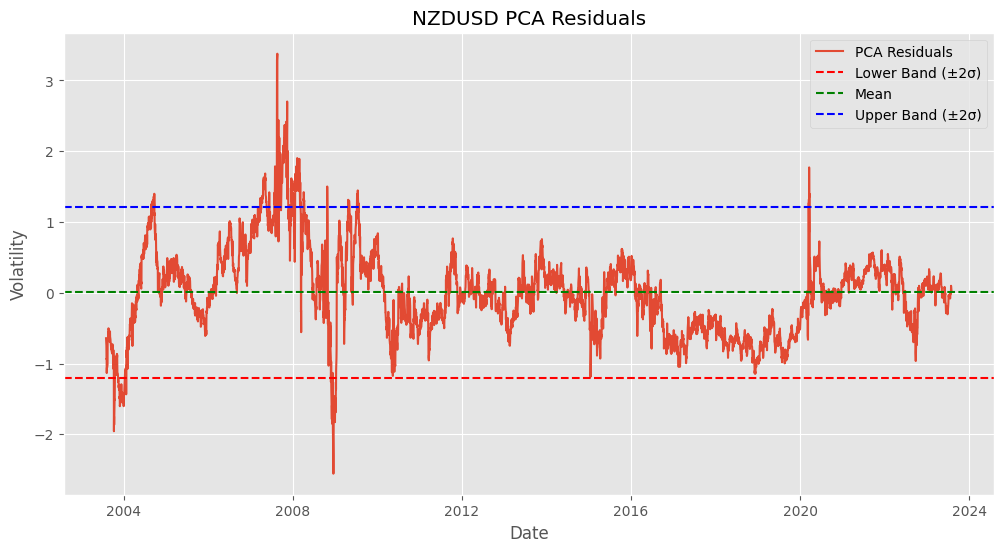

In [71]:
myPCA = PCA(n_components=2)
myPCA.fit(df1y_clean.loc[idx])
residuals = df1y_clean.loc[idx] - myPCA.inverse_transform(
    myPCA.fit_transform(df1y_clean.loc[idx])
)
print(
    "Critial value for ADF statistics on 95%% signicance level = %.2f"
    % tableADF(len(idx), 0)[1]
)
for c in df1y.columns:
    price_series = residuals[c]
    # p_value = ts.adfuller(price_series, regression='c', autolag=None, maxlag=1)[1]
    adf = AugmentedDickeyFuller(price_series, autolag=None, maxlag=1)
    adf.fit()
    _, mu, sigma_eq, hl = fit_uo_params(price_series)
    print(
        "ADF Statistic: %.2f Mean: %.2f Std Dev: %.2f Half-Life: %.2f"
        % (adf.coeff, mu, sigma_eq, hl)
    )
    # print (c, p_value, hl, sigma_eq)
    # price_series.iplot(title=c+' PCA Residuals', xTitle='Date', yTitle='Volatility',
    #                    hline=[mu-2*sigma_eq, mu, mu+2*sigma_eq])
    plt.figure(figsize=(12, 6))
    plt.plot(price_series.index, price_series, label="PCA Residuals")
    plt.axhline(
        y=mu - 2 * sigma_eq, color="r", linestyle="--", label="Lower Band (±2σ)"
    )
    plt.axhline(y=mu, color="g", linestyle="--", label="Mean")
    plt.axhline(
        y=mu + 2 * sigma_eq, color="b", linestyle="--", label="Upper Band (±2σ)"
    )
    plt.title(f"{c} PCA Residuals")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.show()

We've uncovered some valuable findings. If we take the price and neutralize its market factors exposure with the first two Principal Components, the resulting portfolio exhibits mean-reversion with properties highly favorable for a trading z-score band strategy.

This approach gained popularity after the publication of the paper "Statistical Arbitrage in the U.S. Equities Market" by Avellaneda and Lee. In the paper, the authors proposed a statistical arbitrage strategy for U.S. equities where z-scores of PCA residuals were used as signals. However, Avellaneda and Lee emphasize that they don't intend to trade every stock against its factors portfolio. Instead, they suggest that many stocks are traded in both directions, and neutralization of factors may be needed only in small sizes for the net position. This argumentation works well for a universe of thousands of stocks, but there is not as much room for such netting in the universe of 8 currencies. It means that if I adopt the same approach, very often with one signal, I have to make 8 trades. For the OTC-traded instrument, it is operationally impractical and costly, involving a lot of trading and position keeping in uneven and small sizes. Therefore, a rational practitioner would probably not trade the whole Principal Component portfolio and instead substitute it with one or two currencies. This implies that they end up trading just long/short spreads, triplets (maybe quadruplets). In this case, generating trade signals from a higher-dimensional model like PCA is less preferable than from the direct application of cointegrating analysis applied to pairs, triplets, and quadruplets.

## Constructing a systematic strategy

As discussed earlier, our primary attempt to construct a systematic strategy for statistical arbitrage is based on cointegration analysis with Engle-Granger and Johansen procedures. In this chapter, I propose such a strategy. My strategy is intentionally simplified. At this point, my goal is not to present a strategy 100% ready for putting into production, but to answer the question of whether the approach can result in something investable and viable. There is room for improvement, especially in areas like parameter optimization and risk weighing. At the same time, I believe that if the strategy works, it should work with the most straightforward implementation possible. Therefore, it is crucial for us to answer a simple question: If at some point in time $t$, we estimate the model parameters based on some look-back period and construct a trading rule based on these parameters, does this trading rule provide a trading edge for some forward period, and does the behavior of the P&L stream meet our expectations? To answer these questions, I conduct a simple backtest of the following strategy.

Here is the plan:
1. Utilize the first $k$ calendar years of data to estimate cointegrating relationships and assess statistical properties of mean-reversion. Here, $k$ is a parameter (I use $k=5$ as an example). Go through all pairs in the estimation subset and apply the Engle-Granger procedure. Similarly, examine all triplets and quadruplets and apply the Johansen procedure. The outcome of this step is a collection of cointegrated portfolios. For each portfolio, fit the Ornstein-Uhlenbeck (OU) process and store the estimates. Based on the OU parameter estimation and economic considerations, consider dropping portfolios that are not suitable for trading.

2.Use outputs from step 1 to generate a trading rule and apply this rule to the trading period $(k+1)$th year. In this case, the trading rule is defined by $Z_{\text{in}}$ and $Z_{\text{out}}$, representing the number of $\sigma_{\text{eq}}$ deviations from $\mu_{\text{e}}$ for opening and closing positions. Calculate the P&L for each trading day and store it. Although the trading period, $Z_{\text{in}}$, and $Z_{\text{out}}$ can be parametrized and plugged into the optimizer, I am imposing my own values at this point.

3. Move the estimation window of $k$ calendar years one year forward, starting from the second year of the dataset. Recalculate the estimation as in step 1.

4. Repeat step 2 for the $(k+2)$th year based on the estimates from step 3. Add the P&L to the previously stored results.

5. Continue moving the $k$ years estimation window and one-year trading period. Repeat steps 3 and 4 until the last day of the dataset is included in the trading period.

6. Analyze the P&L time series to determine if the strategy managed to capture any alpha and examine its risk profile.

First, I need to code the procedures for screening cointegrating portfolios in a repeatable manner. These procedures are almost identical to what was used earlier. We systematically sort through all possible pairs, triplets, and quadruplets using Engle-Granger and Johansen. For pairs, I perform estimations twice, swapping dependent and independent variables to choose the best relationship based on t-statistics.

The only tweak is that I normalize the weights to have the same $L^1$ norm. This normalization is crucial to make portfolios comparable to each other. $L^1$ is the norm of choice for several reasons. Primarily, in volatility strategy, we measure the position by net and gross vega. Given that our portfolios are designed to be close to vega-neutral, the $L^1$ norm precisely represents the gross vega of the portfolio. Additionally, when we trade, we incur the cost of bid-offer spread. The easiest way to account for this cost is by multiplying the gross vega by half the bid-offer spread. Assuming the same bid/offer width for all currencies, $L^1$-normalized portfolios will all have the same transaction costs.

Also for convenience I decide that all portfolios should have norm equal to 2
$$||W||_1 = \sum_i |w_i| = 2$$ 
No matter how many currencies we have in the portfolio, it essentially represents a beta-weighted spread between some sub-portfolio of longs and a sub-portfolio of shorts. After normalization, I obtain something that resembles the spread: 1 unit of vega in longs versus 1 unit of vega in shorts. Obviously, due to the betas, it is not going to be exactly like that but still somewhat close.

The procedures below also include the estimation of OU parameters for cointegrating relationships. The output is a table with cointegrating portfolios along with their estimated half-lives, $\mu_e$, and $\sigma_{eq}$.

In [72]:
# TODO: more comments here needed
def get_pairs_EG(df):
    cointegrated_portfolios = []
    adf_critical = tableADF(len(df), 0)[1]
    st_critical = t.ppf(0.05, len(df) - 2)
    pairs = df.columns
    for i, c1 in enumerate(pairs):
        for c2 in pairs[i + 1 :]:
            EG1 = EngleGranger(df[c1], df[c2])
            EG1.fit()
            EG2 = EngleGranger(df[c2], df[c1])
            EG2.fit()
            EG = None
            if (EG1.ADFstat < adf_critical) and (EG1.ecm_tstat < st_critical):
                if (EG2.ADFstat < adf_critical) and (EG2.ecm_tstat < EG1.ecm_tstat):
                    EG = EG2
                    portfolio = (c2, c1)
                else:
                    EG = EG1
                    portfolio = (c1, c2)
            elif (EG2.ADFstat < adf_critical) and (
                EG2.ecm_tstat < st_critical
            ):  # checking which relationship is more significant
                EG = EG2
                portfolio = (c2, c1)
            if EG != None:
                norm_factor = float(2 / (1 + abs(EG.coeff[1])))
                res = (EG.residuals + EG.coeff[0]) * norm_factor
                norm_coeff = [norm_factor, -EG.coeff[1] * norm_factor]
                _, mu, sigma_eq, hl = fit_uo_params(res)
                cointegrated_portfolios.append(
                    [list(portfolio), norm_coeff, hl, mu, sigma_eq]
                )

    return pd.DataFrame(
        cointegrated_portfolios,
        columns=["Portfolio", "Weights", "Half-Life", "Mean", "Std"],
    )


def get_triplets_J(df):
    cointegrated_portfolios = []
    pairs = df.columns
    for i, c1 in enumerate(pairs):
        for j, c2 in enumerate(pairs[i + 1 :]):
            for c3 in pairs[i + j + 2 :]:
                data = df[[c1, c2, c3]]
                res = coint_johansen(data, det_order=1, k_ar_diff=1)
                for d in range(3):
                    if (res.lr2[d] > res.cvm[d, 1]) and (res.lr1[d] > res.cvt[d, 1]):
                        norm = sum(abs(res.evec[:, d])) / 2
                        vec_norm = res.evec[:, d] / norm
                        portfolio_value = data.dot(vec_norm)
                        _, mu, sigma_eq, hl = fit_uo_params(portfolio_value)
                        cointegrated_portfolios.append(
                            [[c1, c2, c3], list(vec_norm), hl, mu, sigma_eq]
                        )
                    else:
                        break
    return pd.DataFrame(
        cointegrated_portfolios,
        columns=["Portfolio", "Weights", "Half-Life", "Mean", "Std"],
    )


def get_quadruplets_J(df):
    cointegrated_portfolios = []
    pairs = df.columns
    for i, c1 in enumerate(pairs):
        for j, c2 in enumerate(pairs[i + 1 :]):
            for k, c3 in enumerate(pairs[i + j + 2 :]):
                for c4 in pairs[i + j + k + 3 :]:
                    data = df[[c1, c2, c3, c4]]
                    res = coint_johansen(data, det_order=1, k_ar_diff=1)
                    for d in range(3):
                        if (res.lr2[d] > res.cvm[d, 1]) and (
                            res.lr1[d] > res.cvt[d, 1]
                        ):
                            norm = sum(abs(res.evec[:, d])) / 2
                            vec_norm = res.evec[:, d] / norm
                            portfolio_value = data.dot(vec_norm)
                            _, mu, sigma_eq, hl = fit_uo_params(portfolio_value)
                            cointegrated_portfolios.append(
                                [[c1, c2, c3, c4], vec_norm, hl, mu, sigma_eq]
                            )
                        else:
                            break
    return pd.DataFrame(
        cointegrated_portfolios,
        columns=["Portfolio", "Weights", "Half-Life", "Mean", "Std"],
    )

Next, we need a couple of simple auxiliary procedures that filter portfolios and generate trading signals.

First, we filter the cointegrating portfolios. We drop those with a half-life above a certain threshold for obvious reasons. Also, we don't want $\sigma_{eq}$ to be too low because otherwise, the potential profit is too small, it may even be smaller than transaction costs. Also, I drop a portfolio if one of the weights is too low. If we have a portfolio of $n$ currencies but one of them has almost zero weight, then effectively it should be a portfolio of $(n-1)$ currencies and it is likely already included in the set.

The next procedures produce a time series of portfolio values and translate them into z-scores based on $\mu_e$ and $\sigma_{eq}$. Based on the time series of such z-scores, corresponding procedures return a series of positions and trades.

In [73]:
def select_strategies(strategies, min_weight=0.1, max_hl=60, min_std=0.3):
    strategies = strategies[strategies["Std"] > min_std]
    strategies = strategies[strategies["Half-Life"] < max_hl]
    for i in strategies.index:
        w = strategies.loc[i, "Weights"]
        if min(np.abs(w)) < min_weight:
            strategies = strategies.drop(i)
    return strategies


def calculate_value_series(strategies, market_data):
    value_series = pd.DataFrame(index=market_data.index, columns=strategies.index)
    for i in strategies.index:
        p, w = strategies.loc[i, "Portfolio"], strategies.loc[i, "Weights"]
        value_series[i] = market_data.loc[:, p].dot(w)
    return value_series


def calculate_z_scores(strategies, value_series):
    z_scores = pd.DataFrame(index=value_series.index, columns=strategies.index)
    for s in strategies.index:
        z_scores[s] = (value_series[s] - strategies.loc[s, "Mean"]) / strategies.loc[
            s, "Std"
        ]
    return z_scores


def get_position(z_scores, ol=-2, cl=-1, os=2, cs=1):
    position = pd.DataFrame(0, index=z_scores.index, columns=z_scores.columns)
    position.iloc[0] = np.where(
        z_scores.iloc[0] <= ol, 1, np.where(z_scores.iloc[0] >= os, -1, 0)
    )
    for i in range(1, len(z_scores.index)):
        position.iloc[i] = np.where(
            z_scores.iloc[i] <= ol,
            1,
            np.where(
                z_scores.iloc[i] >= os,
                -1,
                np.where(
                    (z_scores.iloc[i] < cl) & (position.iloc[i - 1] == 1),
                    1,
                    np.where(
                        (z_scores.iloc[i] > cs) & (position.iloc[i - 1] == -1), -1, 0
                    ),
                ),
            ),
        )
    return position


def get_trades(position):
    trades = position.diff()
    trades.iloc[0] = position.iloc[0]
    trades.iloc[-1] = -position.iloc[-2]
    return trades

Now we have the required building blocks to try and finally see what the P&L of the strategy looks like.

As I construct the strategy for trading implied volatilities, first, I want to see the performance in terms of vega. Below I stack vega returns from all the signals we receive, and exactly one unit of vega is allocated to each signal. It is, of course, a bit unrealistic because it assumes very easy access to capital. I will relieve this assumption later, but for now, I want to assess the quality of signals.

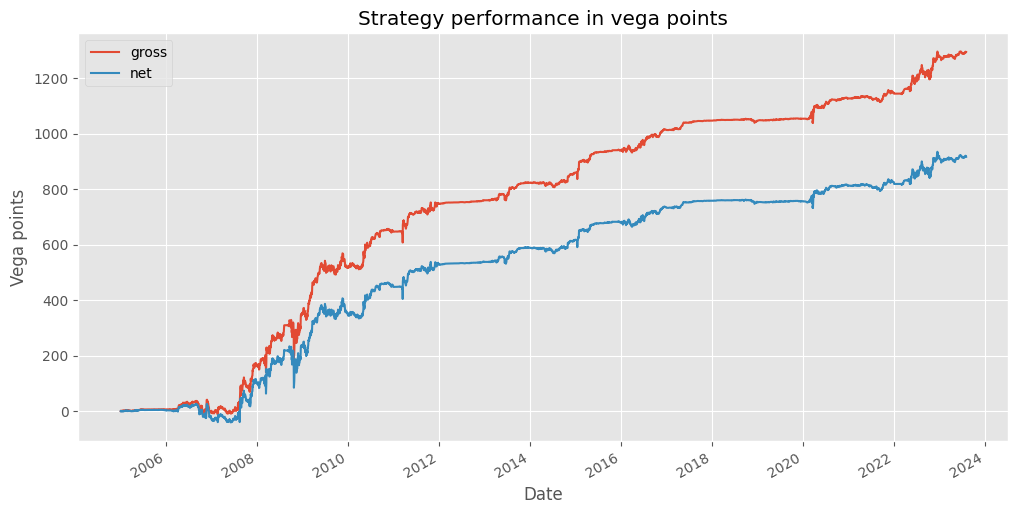

In [74]:
tc = -0.1  # minus half bid/offer (on average)
eoy = pd.date_range(end=df1y.index[-1], start=df1y.index[0], freq="BY")
performance = pd.Series(dtype="float64")
costs = pd.Series(dtype="float64")
performance_ew = pd.Series(dtype="float64")
for i in range(5, len(eoy), 1):
    idx = pd.bdate_range(
        start=eoy[i - 5] + pd.tseries.offsets.DateOffset(days=1), end=eoy[i]
    )
    train_idx = idx.intersection(df1y_clean.index)
    idx = pd.bdate_range(
        end=eoy[i] + pd.tseries.offsets.DateOffset(years=1),
        start=eoy[i] + pd.tseries.offsets.DateOffset(days=1),
    )
    test_idx = idx.intersection(df1y_clean.index)
    strategies = get_pairs_EG(df1y_clean.loc[train_idx])
    strategies = pd.concat(
        [strategies, get_triplets_J(df1y_clean.loc[train_idx])]
    ).reset_index(drop=True)
    strategies = pd.concat(
        [strategies, get_quadruplets_J(df1y_clean.loc[train_idx])]
    ).reset_index(drop=True)
    filtered_strategies = select_strategies(strategies)
    cash_value = calculate_value_series(filtered_strategies, df1y_clean.loc[test_idx])
    zsc = calculate_z_scores(filtered_strategies, cash_value)
    position = get_position(zsc)
    position_ew = position.div(position.abs().sum(axis=1), axis=0)
    trades = get_trades(position)
    costs = pd.concat([costs, (trades.abs() * tc).sum(axis=1)])
    net_performance = performance + costs
    performance = pd.concat(
        [performance, (cash_value.diff().shift(-1) * position).sum(axis=1)]
    )
    performance_ew = pd.concat(
        [performance_ew, (cash_value.diff().shift(-1) * position_ew).sum(axis=1)]
    )

vega_pts = pd.concat(
    [performance.cumsum(), (performance + costs).cumsum(), performance_ew.cumsum()],
    axis=1,
)
vega_pts.columns = ["gross", "net", "ew"]
# vega_pts[['gross', 'net']].iplot(title='Strategy performance in vega points', xTitle='Date', yTitle='Vega points')
vega_pts[["gross", "net"]].plot(
    title="Strategy performance in vega points",
    xlabel="Date",
    ylabel="Vega points",
    figsize=(12, 6),
)
plt.show()

Well, the signals seem to produce an edge. The curve crawls up, outperforming its transaction costs, although in the last ten years, it does not rise as fast as in the previous ten. A couple of observations need to be made. First of all, the scale hides it a bit, but the GFC period was sometimes rough for the strategy. Second, there are periods of steep growth and also periods when performance almost flatlined. That is because we allow the strategy to be almost not invested in periods when there are not many opportunities. And also because we allow it to enormously balloon the investment up at times when there are lots of signals.

Clearly, a more natural case is when you have a certain risk budget and have to make a decision on how to allocate it between available opportunities. I consider the case when the risk budget is fixed in gross vega terms, and the allocation is simply equal weight, so every day I split one unit of vega equally between all signals.

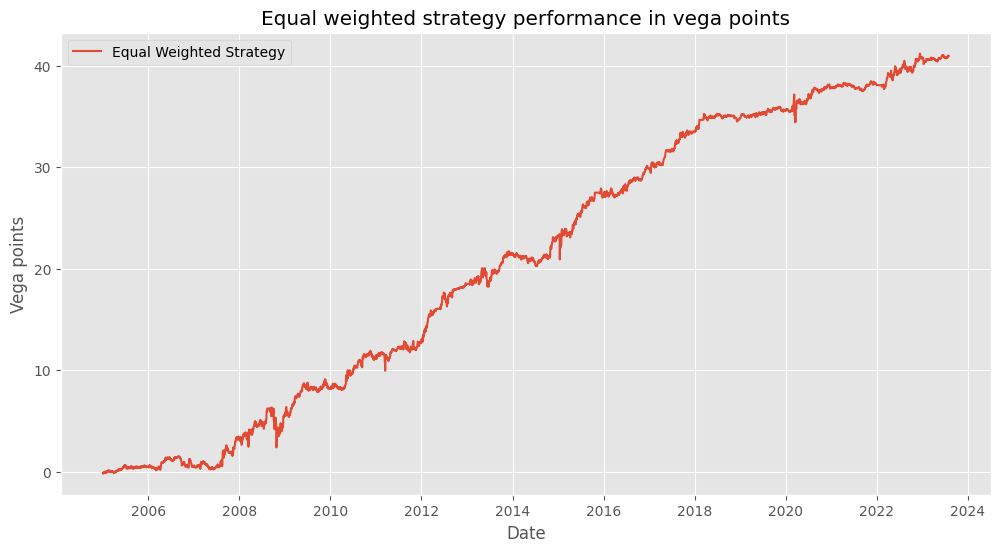

In [75]:
# vega_pts['ew'].iplot(title='Equal weighted strategy performance in vega points', xTitle='Date', yTitle='Vega points')
plt.figure(figsize=(12, 6))
plt.plot(vega_pts.index, vega_pts["ew"], label="Equal Weighted Strategy")
plt.title("Equal weighted strategy performance in vega points")
plt.xlabel("Date")
plt.ylabel("Vega points")
plt.legend()
plt.grid(True)
plt.show()

Because the risk allocation measured in gross vega is constant, the curve here is smoother than on the previous chart.

The curve is trending up, but I want to understand the nature of returns. Do we really capture any alpha here, or maybe we just exploit the fact that on average, FX vol has decreased over the past two decades?

I use JPMorgan G10 FX Volatility 1Y index as a market factor and regress daily strategy vega performance on the daily change in the index.

In [76]:
df_benchmark = pd.read_excel("G10VI.xlsx", parse_dates=["Dates"], index_col="Dates")
df_benchmark = df_benchmark.ffill().dropna()
df_benchmark = df_benchmark.loc[vega_pts.index]
reg = LinearRegression(df_benchmark.diff().dropna(), vega_pts["ew"].diff().dropna())
reg.fit()
table = pd.DataFrame(
    index=["Coefficient", "T-statistic"],
    columns=["Intercept", "Beta"],
    data=[reg.coeff, reg.tstatistics()],
)
table.style.format("{:.3f}")

,Intercept,Beta
Coefficient,0.008,-0.018
T-statistic,4.691,-1.719


We get an interesting result here. Positive statistically significant alpha and a small but negative beta on the border of significance. The former is a good thing and the reason why the whole project is done. The latter actually should have been expected. The rise of the FX volatility index usually coincides with the rise in the volatility of FX implied volatility. These periods may provide good entry opportunities for trading cointegration. But in the short term, already open positions tend to suffer significantly.

But maybe our one-factor model is too simple, and we fool ourselves with positive alpha because it is actually the effect of some omitted beta. Unfortunately, Fama and French did not care about FX vol enough to provide factors. Luckily, above we already figured that the market is probably driven by two meaningful factors and even computed them from the data using PCA.

In [77]:
factors = factors.loc[vega_pts.index]
reg = LinearRegression(
    factors.iloc[:, :2].diff().dropna(), vega_pts["ew"].diff().dropna()
)
reg.fit()
table = pd.DataFrame(
    index=["Coefficient", "T-statistic"],
    columns=["Intercept", "Beta1", "Beta2"],
    data=[reg.coeff, reg.tstatistics()],
)
table.style.format("{:.3f}")

,Intercept,Beta1,Beta2
Coefficient,0.008,-0.008,0.006
T-statistic,4.691,-1.822,0.511


The results tell us the same story as above, and the second factor has no significance.

Now we return to the one-factor index regression and try to analyze rolling beta.

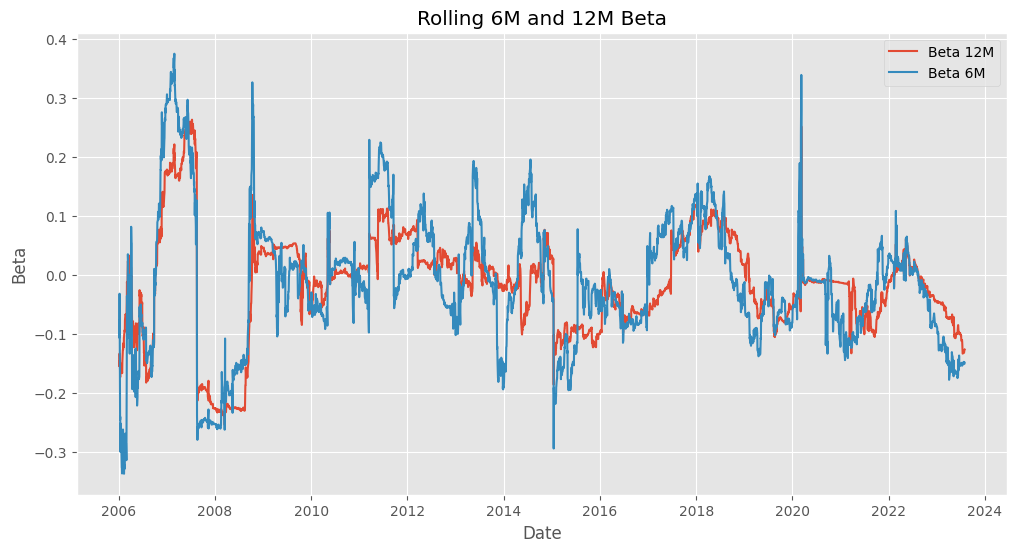

In [78]:
df_bm_change, daily_vega_pts = (
    df_benchmark.diff().dropna(),
    vega_pts["ew"].diff().dropna(),
)
rolling_beta = pd.DataFrame(
    index=daily_vega_pts.index[260:], columns=["Beta 12M", "Beta 6M"]
)
for d in rolling_beta.index:
    idx1 = pd.bdate_range(start=d + pd.tseries.offsets.DateOffset(years=-1), end=d)
    idx1 = idx1.intersection(df_bm_change.index)
    reg = LinearRegression(df_bm_change.loc[idx1], daily_vega_pts.loc[idx1])
    reg.fit()
    rolling_beta.loc[d, "Beta 12M"] = reg.coeff[1]
    idx2 = pd.bdate_range(start=d + pd.tseries.offsets.DateOffset(months=-6), end=d)
    idx2 = idx2.intersection(df_bm_change.index)
    reg = LinearRegression(df_bm_change.loc[idx2], daily_vega_pts.loc[idx2])
    reg.fit()
    rolling_beta.loc[d, "Beta 6M"] = reg.coeff[1]
# rolling_beta.iplot(title='Rolling 6M and 12M Beta', xTitle='Date', yTitle='Beta')
plt.figure(figsize=(12, 6))
plt.plot(rolling_beta.index, rolling_beta["Beta 12M"], label="Beta 12M")
plt.plot(rolling_beta.index, rolling_beta["Beta 6M"], label="Beta 6M")
plt.title("Rolling 6M and 12M Beta")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.grid(True)
plt.show()

Rolling beta can be quite variable. Visually, it looks like during times of market volatility, rolling beta tends to be at the extreme level, but it is hard to determine in advance whether it will be positive or negative.

Now, finally, I want to see the performance in dollar terms rather than vega points. I would say that a Ferrari dealership does not take payments in vega points, but unfortunately, it does not accept backtested dollars either. Going from vega to notional trading can be tricky because from the beginning my goal was to do it without a full option backtesting framework. Luckily, the strategy trades at-the-money volatility, so we have a decent approximation for premium and vega. Double luck is that we mostly only need the ratio between $vega and $premium.
$$ATM\ straddle \ in \ \% \approx 0.8\sigma \sqrt{T}$$
We construct the following absolute return strategy:
1. We start with one 1$ of capital
2. Each day we allocate capital to generate position of $\psi C_t$ dollars in terms of gross vega, equally allocated between signals. Where $C_t$ is amount of capital available at time $t$. 
3. Rest of the capital which is apprximately $C_t(1 - \psi (\mathbf {\sigma_t \cdot w_t}))$ is allocated to treasury bills market. Here $\mathbf {\sigma_t}$ is vectors of market voltilites and $\mathbf{w_t}$ is vector of portfolio weights. I use 3M bills rate while techically I should use overnight rate.
4. On daily basis we compound interest and vega P&L and rebalance the portfolio

Below is the backtest of the strategy for very conservative $\psi =3.3\%$

In [79]:
dfust = pd.read_excel("UST3M.xlsx", parse_dates=["Dates"], index_col="Dates")
dfust.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6418 entries, 1999-01-01 to 2023-08-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3M T    6418 non-null   float64
dtypes: float64(1)
memory usage: 100.3 KB


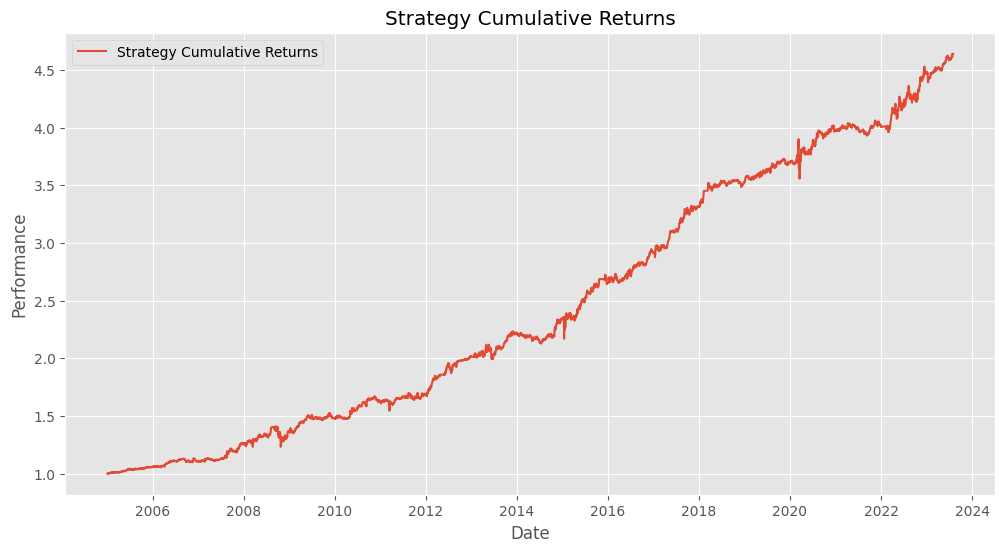

In [80]:
performance = pd.Series(dtype="float64")
psi = 0.033
for i in range(5, len(eoy), 1):
    idx = pd.bdate_range(
        start=eoy[i - 5] + pd.tseries.offsets.DateOffset(days=1), end=eoy[i]
    )
    train_idx = idx.intersection(df1y_clean.index)
    idx = pd.bdate_range(
        end=eoy[i] + pd.tseries.offsets.DateOffset(years=1),
        start=eoy[i] + pd.tseries.offsets.DateOffset(days=1),
    )
    test_idx = idx.intersection(df1y_clean.index)
    strategies = get_pairs_EG(df1y_clean.loc[train_idx])
    strategies = pd.concat(
        [strategies, get_triplets_J(df1y_clean.loc[train_idx])]
    ).reset_index(drop=True)
    strategies = pd.concat(
        [strategies, get_quadruplets_J(df1y_clean.loc[train_idx])]
    ).reset_index(drop=True)
    filtered_strategies = select_strategies(strategies)
    cash_value = calculate_value_series(filtered_strategies, df1y_clean.loc[test_idx])
    zsc = calculate_z_scores(filtered_strategies, cash_value)
    position = get_position(zsc)
    position = position.div(position.abs().sum(axis=1), axis=0)
    vol_performance = psi * (cash_value.diff().shift(-1) * position).sum(axis=1)
    cash_performance = (dfust.loc[position.index]).multiply(
        position.index.to_series().diff().dt.days, axis="index"
    ).multiply((1 - psi * (cash_value * position).sum(axis=1)), axis="index") / 36000
    performance = pd.concat([performance, cash_performance.squeeze() + vol_performance])
# (1 + performance).cumprod().iplot(title='Strategy Cumulative Returns', xTitle='Date', yTitle='Performance')
plt.figure(figsize=(12, 6))
plt.plot((1 + performance).cumprod(), label="Strategy Cumulative Returns")
plt.title("Strategy Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Performance")
plt.legend()
plt.grid(True)
plt.show()

Below is the backtest of the strategy in pyfolio. The strategy is definetely investable but also may be too cautious even for my conservative taste, but by tweaking the parameter $\psi$, we can make it really aggressive. At some level of the parameter, the allocation to T-bills becomes negative. We can think of it as borrowing from the market.

Start date,2005-01-03
End date,2023-08-01
Total months,230
,Backtest
Annual return,8.311%
Cumulative returns,363.971%
Annual volatility,6.586%
Sharpe ratio,1.25
Calmar ratio,0.67
Stability,0.99
Max drawdown,-12.459%


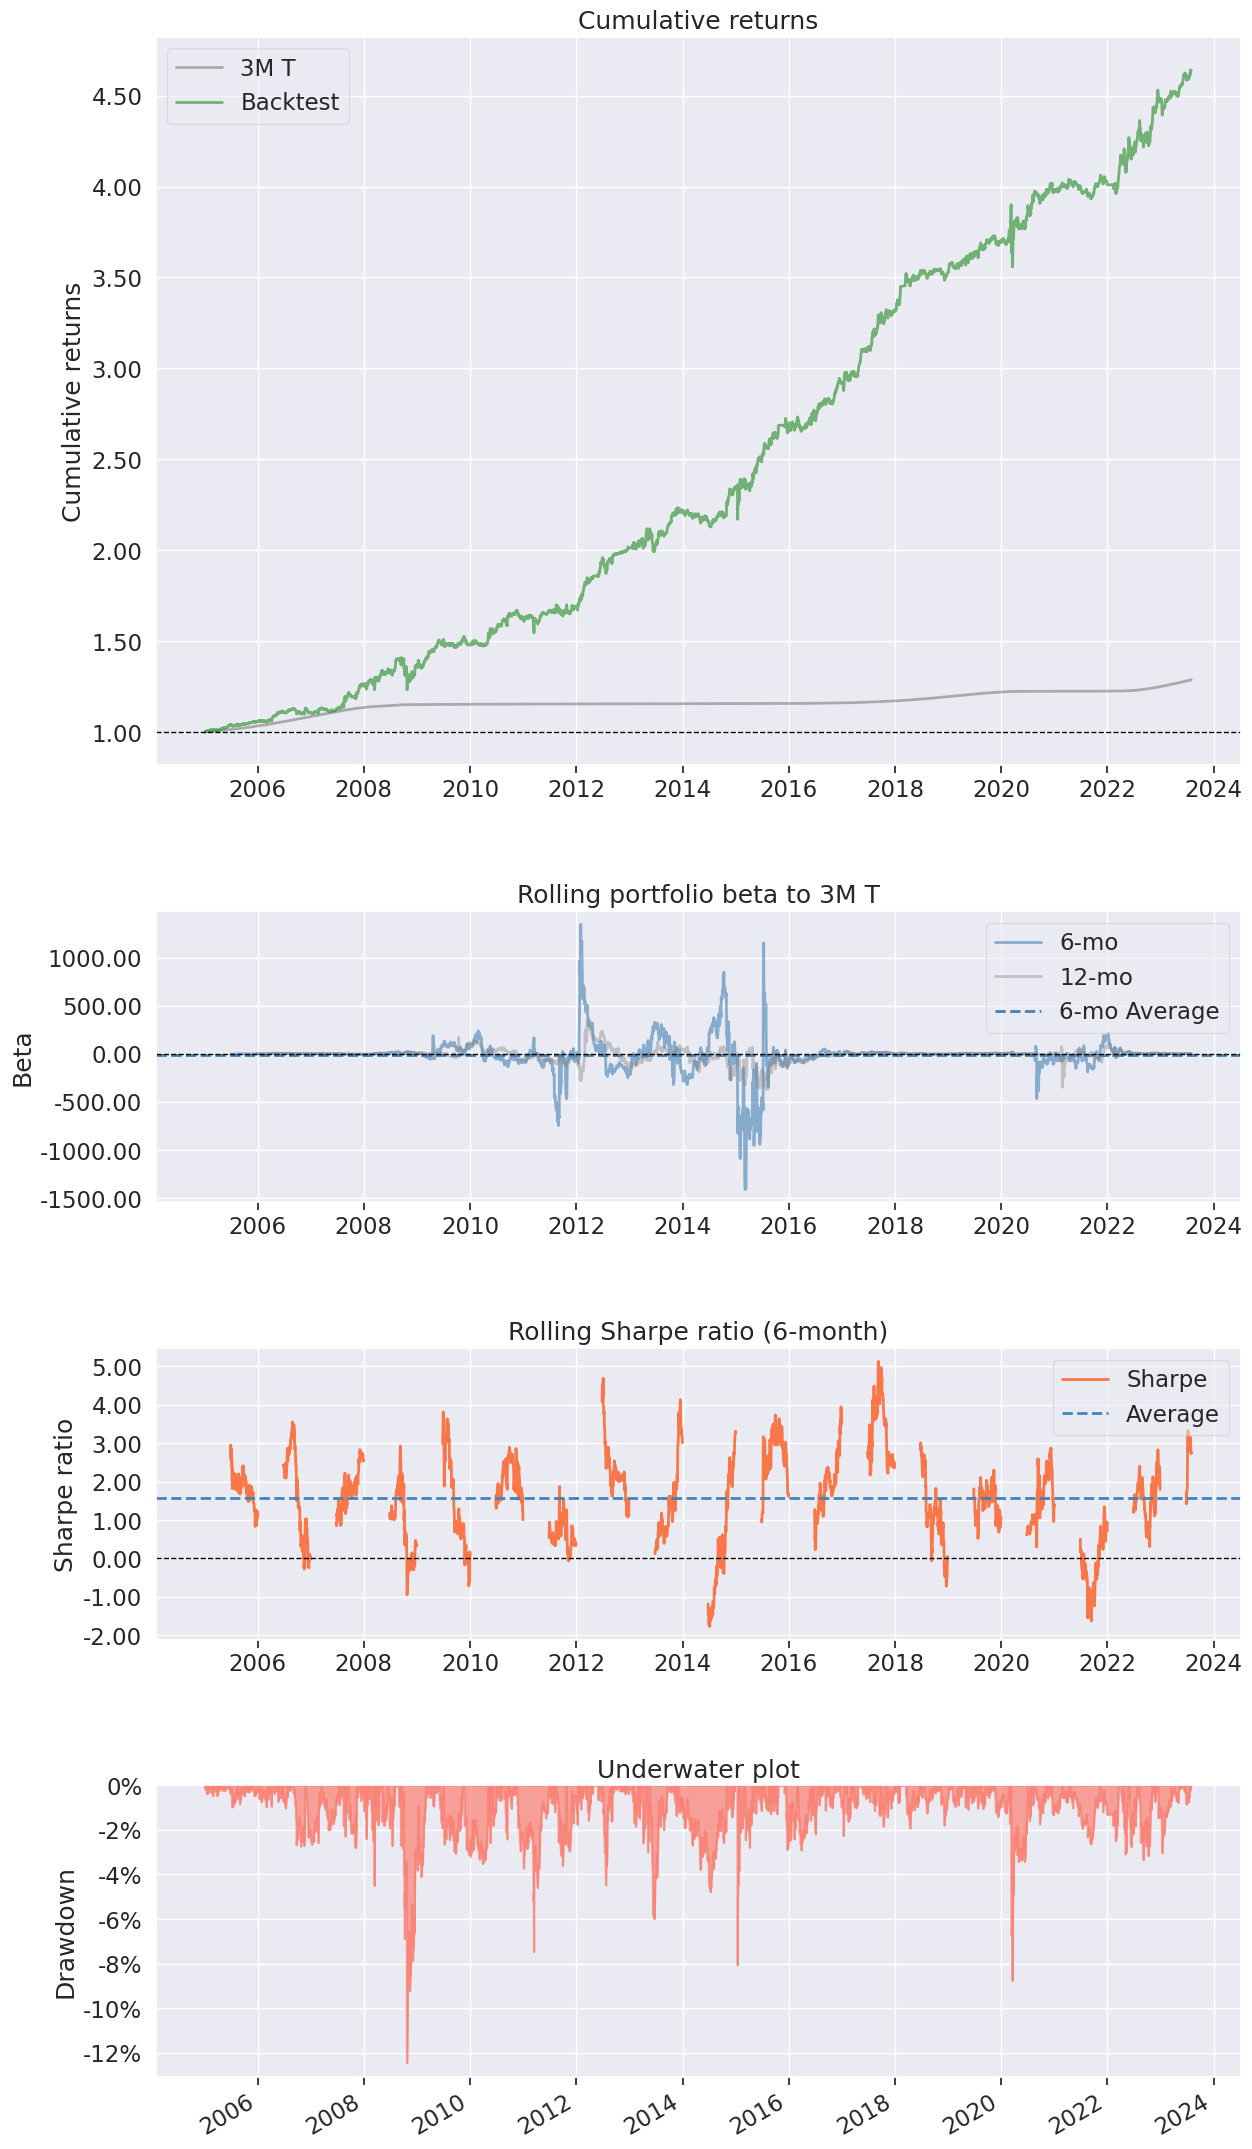

In [81]:
import pyfolio as pf

pf.create_simple_tear_sheet(
    performance,
    benchmark_rets=dfust.loc[performance.index]
    .multiply(performance.index.to_series().diff().dt.days, axis="index")
    .squeeze()
    / 36000,
)

## Conclusion

I believe I have successfully demonstrated that the FX volatility market holds significant potential for systematic mean-reversion trading. While the strategy exhibits a clear edge, it is imperative to conduct a thorough and rigorous backtest for accurate estimation of the Sharpe ratio and risk parameters before considering live trading.

Exploring ways to enhance the strategy is another avenue for future development.Potential parameter space is huge and avoinding data mining and overfitting issues will be more an art rather than science. First, I would probably take a look at more frequent reestimation of cointegrating relations, shorter lookback period, time stop less in case the carry is not favourable and of course tighter trading bounds.

Obviously, there is a huge room in improving the weights. Correlation between the values of cointegrating portfolios can be very high as we utilise dozens of such strategies based on only 8 prices. This means a more intelligent allocation of exposure could significantly reduce risks compared to the baseline model outlined above.